# **0. Load Preliminary Functions**

# a. Import Libraries and Functions

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
tqdm = tqdm
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"  # 允许重复加载 OpenMP

# b. MNIST Data Loader

In [3]:
tensor_transform = transforms.ToTensor()

batch_size = 256
MNIST_dataset = datasets.MNIST(root = "./data",
									train = True,
									download = True,
									transform = tensor_transform)

MNIST_loader = torch.utils.data.DataLoader(dataset = MNIST_dataset,
							   batch_size = batch_size,
								 shuffle = True)


# c. Training Function

In [4]:
from math import e
mse = torch.nn.MSELoss()

def loss_func(model, x, reg_func=None, coeff=1e-3):
    output = model(x)
    err = mse(output['imgs'], x)
    logpx_z = -1.0 * torch.sum(err)

    if reg_func is not None:
      reg = reg_func(output)
    else:
      reg = 0.0

    return -1.0 * torch.mean(logpx_z + coeff * reg)

def train(dataloader, model, loss_func, optimizer, epochs):
    losses = []

    for epoch in tqdm(range(epochs), desc='Epochs'):
        running_loss = 0.0
        batch_progress = tqdm(dataloader, desc='Batches', leave=False)

        for iter, (images, labels) in enumerate(batch_progress):
            batch_size = images.shape[0]
            images = images.reshape(batch_size, -1).to(device)
            loss = loss_func(model, images)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            avg_loss = running_loss / len(MNIST_dataset) * batch_size
            losses.append(loss.item())

        tqdm.write(f'----\nEpoch [{epoch+1}/{epochs}], Average Loss: {avg_loss:.4f}\n')

    return losses


# d. Evaluation Function

In [5]:
def plot_latent_images(model, n, digit_size=28):
    grid_x = np.linspace(-2, 2, n)
    grid_y = np.linspace(-2, 2, n)

    image_width = digit_size * n
    image_height = digit_size * n
    image = np.zeros((image_height, image_width))

    for i, yi in enumerate(grid_x):
        for j, xi in enumerate(grid_y):
            z = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            with torch.no_grad():
                x_decoded = model.decode(z)
            digit = x_decoded.view(digit_size, digit_size).cpu().numpy()
            image[i * digit_size: (i + 1) * digit_size,
                  j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    plt.imshow(image, cmap='Greys_r')
    plt.axis('Off')
    plt.show()


def eval(model):
    original_imgs = torch.cat([MNIST_dataset[i][0] for i in range(5)])
    with torch.no_grad():
      res = model(original_imgs.reshape(5, -1).to(device))
      reconstructed_imgs = res['imgs']
      reconstructed_imgs = reconstructed_imgs.cpu().reshape(*original_imgs.shape)

    fig, axes = plt.subplots(5, 2, figsize=(10, 25))

    for i in range(5):
        original_image = original_imgs[i].reshape(28, 28)
        axes[i, 0].imshow(original_image, cmap='gray')
        axes[i, 0].set_title(f'Original Image {i+1}')
        axes[i, 0].axis('off')

        reconstructed_image = reconstructed_imgs[i].reshape(28, 28)
        axes[i, 1].imshow(reconstructed_image, cmap='gray')
        axes[i, 1].set_title(f'Reconstructed Image {i+1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()


# **1. AutoEncoder (AE)**

## a. Model


In [6]:
class AE(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims):
        super().__init__()

        assert hidden_dims[-1] == 2, "always use 2 as the latent dimension for generating a 2D image grid during evaluation"
        encoder_layer = []
        decoder_layer = []
        prev_dim = input_dim
        for i in hidden_dims:
            encoder_layer.append(torch.nn.Linear(prev_dim, i))
            encoder_layer.append(torch.nn.ReLU())
            prev_dim = i
        prev_dim = hidden_dims[-1]
        for i in range(len(hidden_dims)-2, -2, -1):
            if i < 0:
                decoder_layer.append(torch.nn.Linear(hidden_dims[0], input_dim))
            else:
                decoder_layer.append(torch.nn.Linear(prev_dim, hidden_dims[i]))
                decoder_layer.append(torch.nn.ReLU())
                prev_dim = hidden_dims[i]
        self.encoder = torch.nn.Sequential(*encoder_layer[:-1])
        self.decoder = torch.nn.Sequential(*decoder_layer)
        # print(self.encoder)
        # print(self.decoder)
        ##################
        ### Problem 1 (a): finish the implementation for encoder and decoder
        ##################

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decode(encoded)
        return {"imgs": decoded}

### Test
hidden_dims = [128, 64, 36, 18, 2]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

ae_test = AE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = ae_test(test_tensor)


## b. Loss Functions and Optimizers


In [7]:
def loss_AE(model, x):
    reconstructed = model(x)['imgs']
    return mse(reconstructed, x)

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

hidden_dims = [128, 32, 16, 2]

ae = AE(input_dim, hidden_dims).to(device)
print(ae)

optimizer_ae = torch.optim.Adam(ae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)


input_dim:  784
AE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=128, bias=True)
    (5): ReLU()
    (6): Linear(in_features=128, out_features=784, bias=True)
  )
)


## c. Training


In [15]:
##################
### Problem 1 (b): Train AE
epochs = 20

log_ae = train(MNIST_loader, ae, loss_AE, optimizer_ae, epochs)
##################


Epochs:   5%|▌         | 1/20 [00:04<01:32,  4.85s/it]

----
Epoch [1/20], Average Loss: 0.0190



Epochs:  10%|█         | 2/20 [00:09<01:26,  4.81s/it]

----
Epoch [2/20], Average Loss: 0.0182



Epochs:  15%|█▌        | 3/20 [00:14<01:18,  4.63s/it]

----
Epoch [3/20], Average Loss: 0.0176



Epochs:  20%|██        | 4/20 [00:18<01:12,  4.53s/it]

----
Epoch [4/20], Average Loss: 0.0172



Epochs:  25%|██▌       | 5/20 [00:22<01:06,  4.47s/it]

----
Epoch [5/20], Average Loss: 0.0169



Epochs:  30%|███       | 6/20 [00:27<01:02,  4.46s/it]

----
Epoch [6/20], Average Loss: 0.0166



Epochs:  35%|███▌      | 7/20 [00:31<00:58,  4.49s/it]

----
Epoch [7/20], Average Loss: 0.0165



Epochs:  40%|████      | 8/20 [00:36<00:53,  4.48s/it]

----
Epoch [8/20], Average Loss: 0.0163



Epochs:  45%|████▌     | 9/20 [00:40<00:49,  4.45s/it]

----
Epoch [9/20], Average Loss: 0.0162



Epochs:  50%|█████     | 10/20 [00:45<00:44,  4.45s/it]

----
Epoch [10/20], Average Loss: 0.0160



Epochs:  55%|█████▌    | 11/20 [00:49<00:39,  4.43s/it]

----
Epoch [11/20], Average Loss: 0.0159



Epochs:  60%|██████    | 12/20 [00:53<00:35,  4.42s/it]

----
Epoch [12/20], Average Loss: 0.0158



Epochs:  65%|██████▌   | 13/20 [00:58<00:30,  4.41s/it]

----
Epoch [13/20], Average Loss: 0.0156



Epochs:  70%|███████   | 14/20 [01:02<00:26,  4.40s/it]

----
Epoch [14/20], Average Loss: 0.0155



Epochs:  75%|███████▌  | 15/20 [01:07<00:22,  4.44s/it]

----
Epoch [15/20], Average Loss: 0.0154



Epochs:  80%|████████  | 16/20 [01:11<00:17,  4.43s/it]

----
Epoch [16/20], Average Loss: 0.0154



Epochs:  85%|████████▌ | 17/20 [01:15<00:13,  4.41s/it]

----
Epoch [17/20], Average Loss: 0.0153



Epochs:  90%|█████████ | 18/20 [01:20<00:08,  4.39s/it]

----
Epoch [18/20], Average Loss: 0.0152



Epochs:  95%|█████████▌| 19/20 [01:24<00:04,  4.36s/it]

----
Epoch [19/20], Average Loss: 0.0152



Epochs: 100%|██████████| 20/20 [01:29<00:00,  4.46s/it]

----
Epoch [20/20], Average Loss: 0.0151



## d. Evaluation


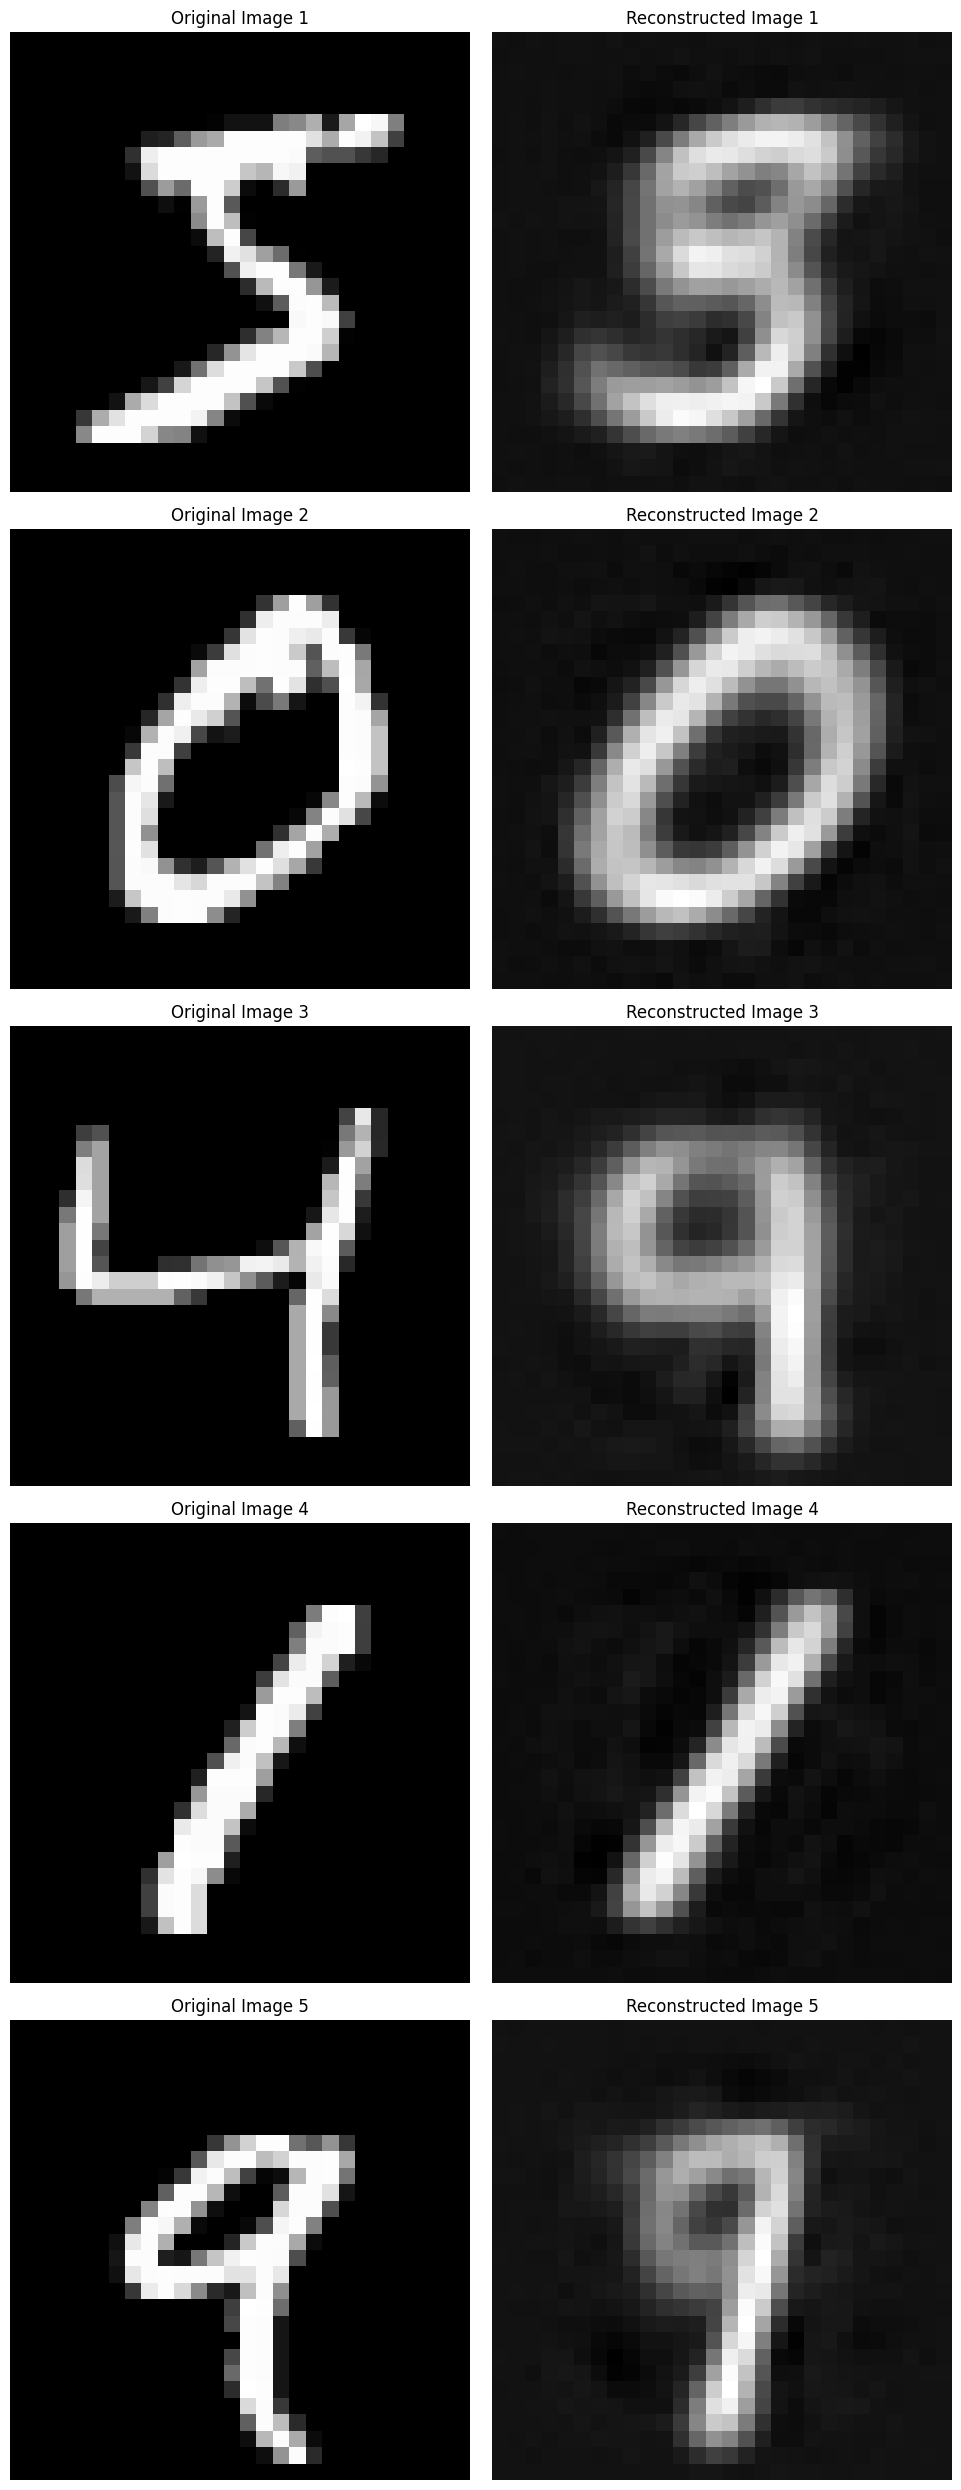

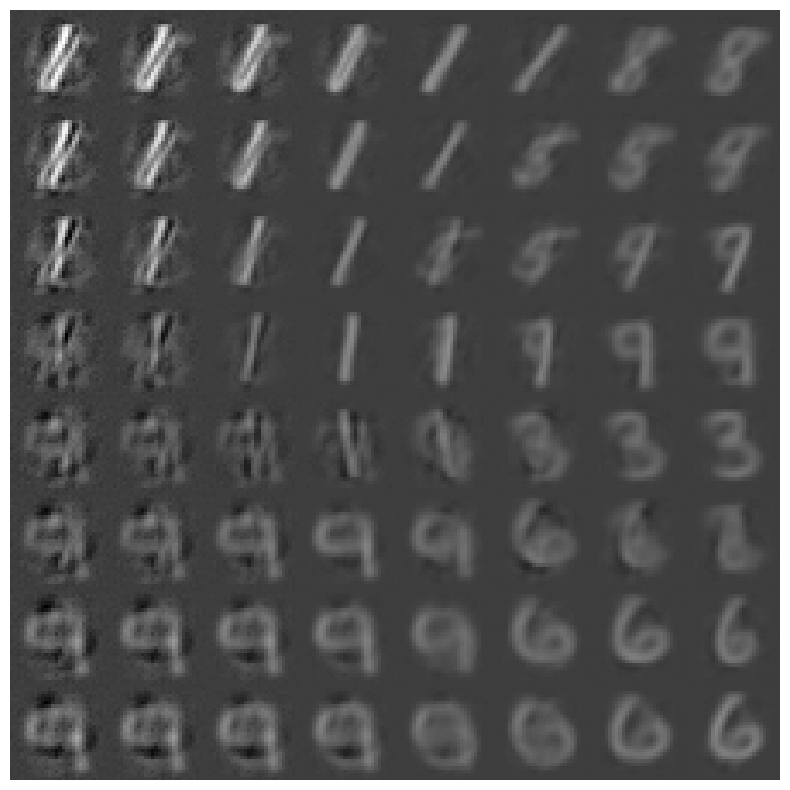

In [16]:
##################
### Problem 1 (b): Evaluate AE
eval(ae)
plot_latent_images(ae, n=8)
##################


# **2. Variational  AutoEncoder (VAE)**
## a. Model

In [12]:
class VAE(torch.nn.Module):
  def __init__(self, input_dim, hidden_dims, decode_dim=-1, use_sigmoid=True):
      '''
      input_dim: The dimensionality of the input data.
      hidden_dims: A list of hidden dimensions for the layers of the encoder and decoder.
      decode_dim: (Optional) Specifies the dimensions to decode, if different from input_dim.
      '''
      super().__init__()

      self.z_size = hidden_dims[-1] // 2
      encoder_layer = []
      decoder_layer = []
      prev = input_dim
      for i in hidden_dims:
         encoder_layer.append(torch.nn.Linear(prev, i))
         encoder_layer.append(torch.nn.ReLU())
         prev = i
      encoder_layer = encoder_layer[:-1]
      prev_dim = hidden_dims[-1]
      decoder_layer.append(torch.nn.Linear(self.z_size, hidden_dims[-1]))
      decoder_layer.append(torch.nn.ReLU())

      for i in range(len(hidden_dims)-2, -2, -1):
            if i < 0:
                if decode_dim == -1:
                    decoder_layer.append(torch.nn.Linear(hidden_dims[0], input_dim))
                else:
                    decoder_layer.append(torch.nn.Linear(hidden_dims[0], decode_dim))

            else:
                decoder_layer.append(torch.nn.Linear(prev_dim, hidden_dims[i]))
                decoder_layer.append(torch.nn.ReLU())
                prev_dim = hidden_dims[i]
      if use_sigmoid:
        decoder_layer.append(torch.nn.Sigmoid())
      self.encoder = torch.nn.Sequential(*encoder_layer)
      self.decoder = torch.nn.Sequential(*decoder_layer)
      # print(self.encoder)
      # print(self.decoder)
      ##################
      ### Problem 2(b): finish the implementation for encoder and decoder
      ##################

  def encode(self, x):
      mean, logvar = torch.split(self.encoder(x), split_size_or_sections=[self.z_size, self.z_size], dim=-1)
      return mean, logvar

  def reparameterize(self, mean, logvar, n_samples_per_z=1):
      ##################
      ### Problem 2(c): finish the implementation for reparameterization
      ##################
      std = torch.exp(0.5 *  logvar)
      eps = torch.randn_like(std)
      z = mean + eps * std
    #   return z if n_samples_per_z == 1 else z.reshape(mean.shape[0] * n_samples_per_z, -1)
      return z
      

  def decode(self, z):
      probs = self.decoder(z)
      return probs

  def forward(self, x, n_samples_per_z=1):
      mean, logvar = self.encode(x)

      batch_size, latent_dim = mean.shape
      if n_samples_per_z > 1:
        mean = mean.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)
        logvar = logvar.unsqueeze(1).expand(batch_size, n_samples_per_z, latent_dim)

        mean = mean.contiguous().view(batch_size * n_samples_per_z, latent_dim)
        logvar = logvar.contiguous().view(batch_size * n_samples_per_z, latent_dim)

      z = self.reparameterize(mean, logvar, n_samples_per_z)
      x_probs = self.decode(z)

      x_probs = x_probs.reshape(batch_size, n_samples_per_z, -1)
      x_probs = torch.mean(x_probs, dim=[1])

      return {
          "imgs": x_probs,
          "z": z,
          "mean": mean,
          "logvar": logvar
      }

### Test
hidden_dims = [128, 64, 36, 18, 18]
input_dim = 256
test_tensor = torch.randn([1, input_dim]).to(device)

vae_test = VAE(input_dim, hidden_dims).to(device)

with torch.no_grad():
  test_out = vae_test(test_tensor)


## b. Loss Functions

### Loss 1: Stoachastic Gradient Variational Bayes (SGVB) Estimator

VAEs are trained by maximizing the Evidence Lower Bound (ELBO) on the marginal log-likelihood:
$$\log p(x) \geq \mathbb{E}_{q(z|x)}[\log\frac{p(x, z)}{q(z|x)}] = \mathrm{ELBO},$$

where $x$ is the data (binary images for MNIST) and $z$ is the latent code.

In practice, the above expectation is estimated using Monte Carlo sampling, yielding the generic Stoachastic Gradient Variational Bayes (SGVB) estimator,
$$\mathrm{ELBO} \approx \sum_{i, j} [\log p(x_i|z_{i, j}) + \log p(z_{i, j}) - \log q(z_{i, j}|x_i)], $$
where $z_{i, j}$ is sampled from $ q(z|x_i) = \mathcal{N}(z;\mu_i, \sigma^2_i \mathbf{I})$. In this assignment, we only sample one $z_{i,j}$ for each $x_i$ (see the function ``reparameterize()`` in the ``VAE()`` class).

In [13]:
##### Loss 1: SGVB #####
log2pi = torch.log(2.0 * torch.tensor(np.pi)).to(device)
torch_zero = torch.tensor(0.0).to(device)

def log_normal_pdf(sample, mean, logvar, raxis=1):
    ##################
    ### Problem 2(d): finish the implementation for the log-probability for normal distribution with mean and var
    ##################
    # print(sample.shape, mean.shape, logvar.shape)
    var = torch.exp(logvar)
    log_prob = -0.5 * ((sample - mean) ** 2 / var + log2pi + logvar)
    return torch.sum(log_prob, dim=raxis)

def loss_SGVB(output):
    logpz = log_normal_pdf(output['z'], torch_zero, torch_zero)
    logqz_x = log_normal_pdf(output['z'], output['mean'], output['logvar'])
    return logpz -logqz_x


### Loss 2: KL Divergence w/o Estimation
In many cases, Monte Carlo sampling is not necessary to estimate all the terms of ELBO, as some terms can be integrated analytically. In the assignment, you derived the cases where the ELBO can be expressed as an analytical KL-divergence plus the expected reconstruction error, specifically when both $q(z|x)$ and $p(z)$ are Gaussian distributions:
$$\mathrm{ELBO} ≈ -D_{KL}(q(z|x) || p(z)) + \sum_{i, j} \log p(x_i|z_{i, j}) = \\\frac{1}{2}\sum_{d}(1+\log((\sigma_d)^2) - (\mu_d)^2 - (\sigma_d)^2) + \sum_{i, j} \log p(x_i|z_{i, j})$$

In [14]:
##### Loss 2: KL w/o Estimation #####
def loss_KL_wo_E(output):
    var = torch.exp(output['logvar'])
    logvar = output['logvar']
    mean = output['mean']

    return -0.5 * torch.sum(torch.pow(mean, 2)
                            + var - 1.0 - logvar,
                            dim=[1])


## c. Verifying loss 1 == loss 2


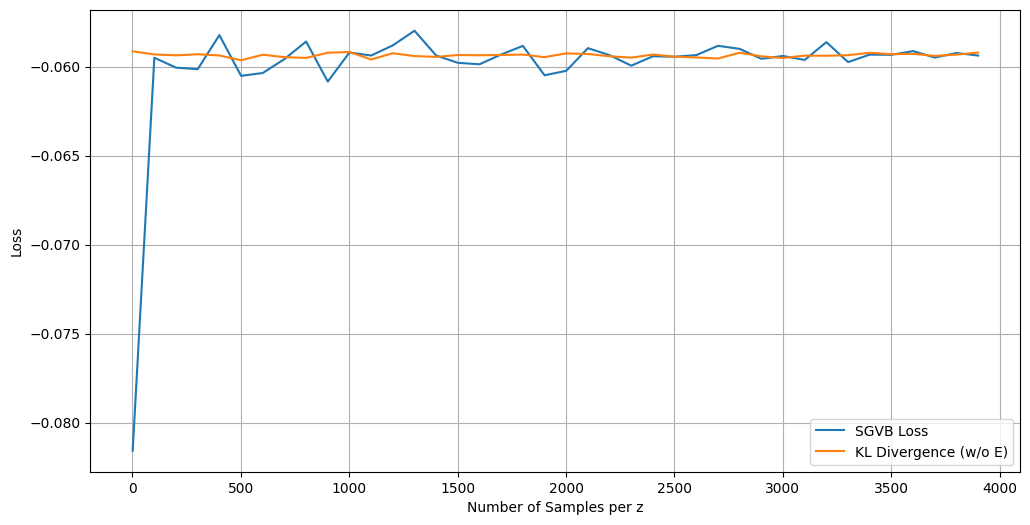

In [24]:
##################
### Problem 3(b): Check if the analytical KL divergence matches the Monte Carlo estimate.
hidden_dims = [128, 32, 16, 4]
image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
vae_test = VAE(input_dim, hidden_dims).to(device)

all_l_sgvb, all_KL_wo_E = [], []
all_n_samples_per_z = list(range(1, 4000, 100))
with torch.no_grad():
    for n_samples_per_z in all_n_samples_per_z:
        for _, (imgs, _) in enumerate(MNIST_loader):
            batch_size = imgs.shape[0]
            imgs = imgs.reshape(batch_size, -1).to(device)

            output = vae_test(imgs, n_samples_per_z=n_samples_per_z)

            l_sgvb = torch.mean(loss_SGVB(output))
            l_KL_wo_E = torch.mean(loss_KL_wo_E(output))

            all_l_sgvb.append(l_sgvb.item())
            all_KL_wo_E.append(l_KL_wo_E.item())
            break

# Plot the two curves
plt.figure(figsize=(12, 6))

plt.plot(all_n_samples_per_z, all_l_sgvb, label='SGVB Loss')
plt.plot(all_n_samples_per_z, all_KL_wo_E, label='KL Divergence (w/o E)')

plt.xlabel('Number of Samples per z')
plt.ylabel('Loss')
plt.legend()

plt.grid(True)
plt.show()
##################


## d. Training with ELBO loss



In [19]:
##################
### Problem 3(c): Train VAE with ELBO loss
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_sgvb = VAE(input_dim, hidden_dims).to(device)
print(vae_sgvb)

coeff = 1e-3

optimizer_vae_sgvb = torch.optim.Adam(vae_sgvb.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_sgvb = train(MNIST_loader, vae_sgvb, lambda model, x: loss_func(model, x, reg_func=loss_SGVB, coeff=1e-3), optimizer_vae_sgvb, epochs)
##################


input_dim:  784
VAE(
  (encoder_base): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
  (fc_mean): Linear(in_features=4, out_features=2, bias=True)
  (fc_logvar): Linear(in_features=4, out_features=2, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


Epochs:   5%|▌         | 1/20 [00:04<01:32,  4.87s/it]

----
Epoch [1/20], Average Loss: 0.0687



Epochs:  10%|█         | 2/20 [00:09<01:25,  4.73s/it]

----
Epoch [2/20], Average Loss: 0.0306



Epochs:  15%|█▌        | 3/20 [00:14<01:20,  4.71s/it]

----
Epoch [3/20], Average Loss: 0.0261



Epochs:  20%|██        | 4/20 [00:19<01:16,  4.75s/it]

----
Epoch [4/20], Average Loss: 0.0252



Epochs:  25%|██▌       | 5/20 [00:23<01:10,  4.68s/it]

----
Epoch [5/20], Average Loss: 0.0249



Epochs:  30%|███       | 6/20 [00:28<01:04,  4.62s/it]

----
Epoch [6/20], Average Loss: 0.0245



Epochs:  35%|███▌      | 7/20 [00:32<00:59,  4.58s/it]

----
Epoch [7/20], Average Loss: 0.0242



Epochs:  40%|████      | 8/20 [00:37<00:55,  4.59s/it]

----
Epoch [8/20], Average Loss: 0.0240



Epochs:  45%|████▌     | 9/20 [00:42<00:53,  4.83s/it]

----
Epoch [9/20], Average Loss: 0.0238



Epochs:  50%|█████     | 10/20 [00:55<01:14,  7.48s/it]

----
Epoch [10/20], Average Loss: 0.0237



Epochs:  55%|█████▌    | 11/20 [01:01<01:00,  6.74s/it]

----
Epoch [11/20], Average Loss: 0.0236



Epochs:  60%|██████    | 12/20 [01:05<00:49,  6.14s/it]

----
Epoch [12/20], Average Loss: 0.0235



Epochs:  65%|██████▌   | 13/20 [01:10<00:39,  5.68s/it]

----
Epoch [13/20], Average Loss: 0.0234



Epochs:  70%|███████   | 14/20 [01:15<00:32,  5.35s/it]

----
Epoch [14/20], Average Loss: 0.0233



Epochs:  75%|███████▌  | 15/20 [01:19<00:25,  5.10s/it]

----
Epoch [15/20], Average Loss: 0.0232



Epochs:  80%|████████  | 16/20 [01:24<00:19,  4.94s/it]

----
Epoch [16/20], Average Loss: 0.0231



Epochs:  85%|████████▌ | 17/20 [01:28<00:14,  4.80s/it]

----
Epoch [17/20], Average Loss: 0.0230



Epochs:  90%|█████████ | 18/20 [01:33<00:09,  4.70s/it]

----
Epoch [18/20], Average Loss: 0.0228



Epochs:  95%|█████████▌| 19/20 [01:37<00:04,  4.68s/it]

----
Epoch [19/20], Average Loss: 0.0226



Epochs: 100%|██████████| 20/20 [01:42<00:00,  5.11s/it]

----
Epoch [20/20], Average Loss: 0.0223



## e. Evaluation

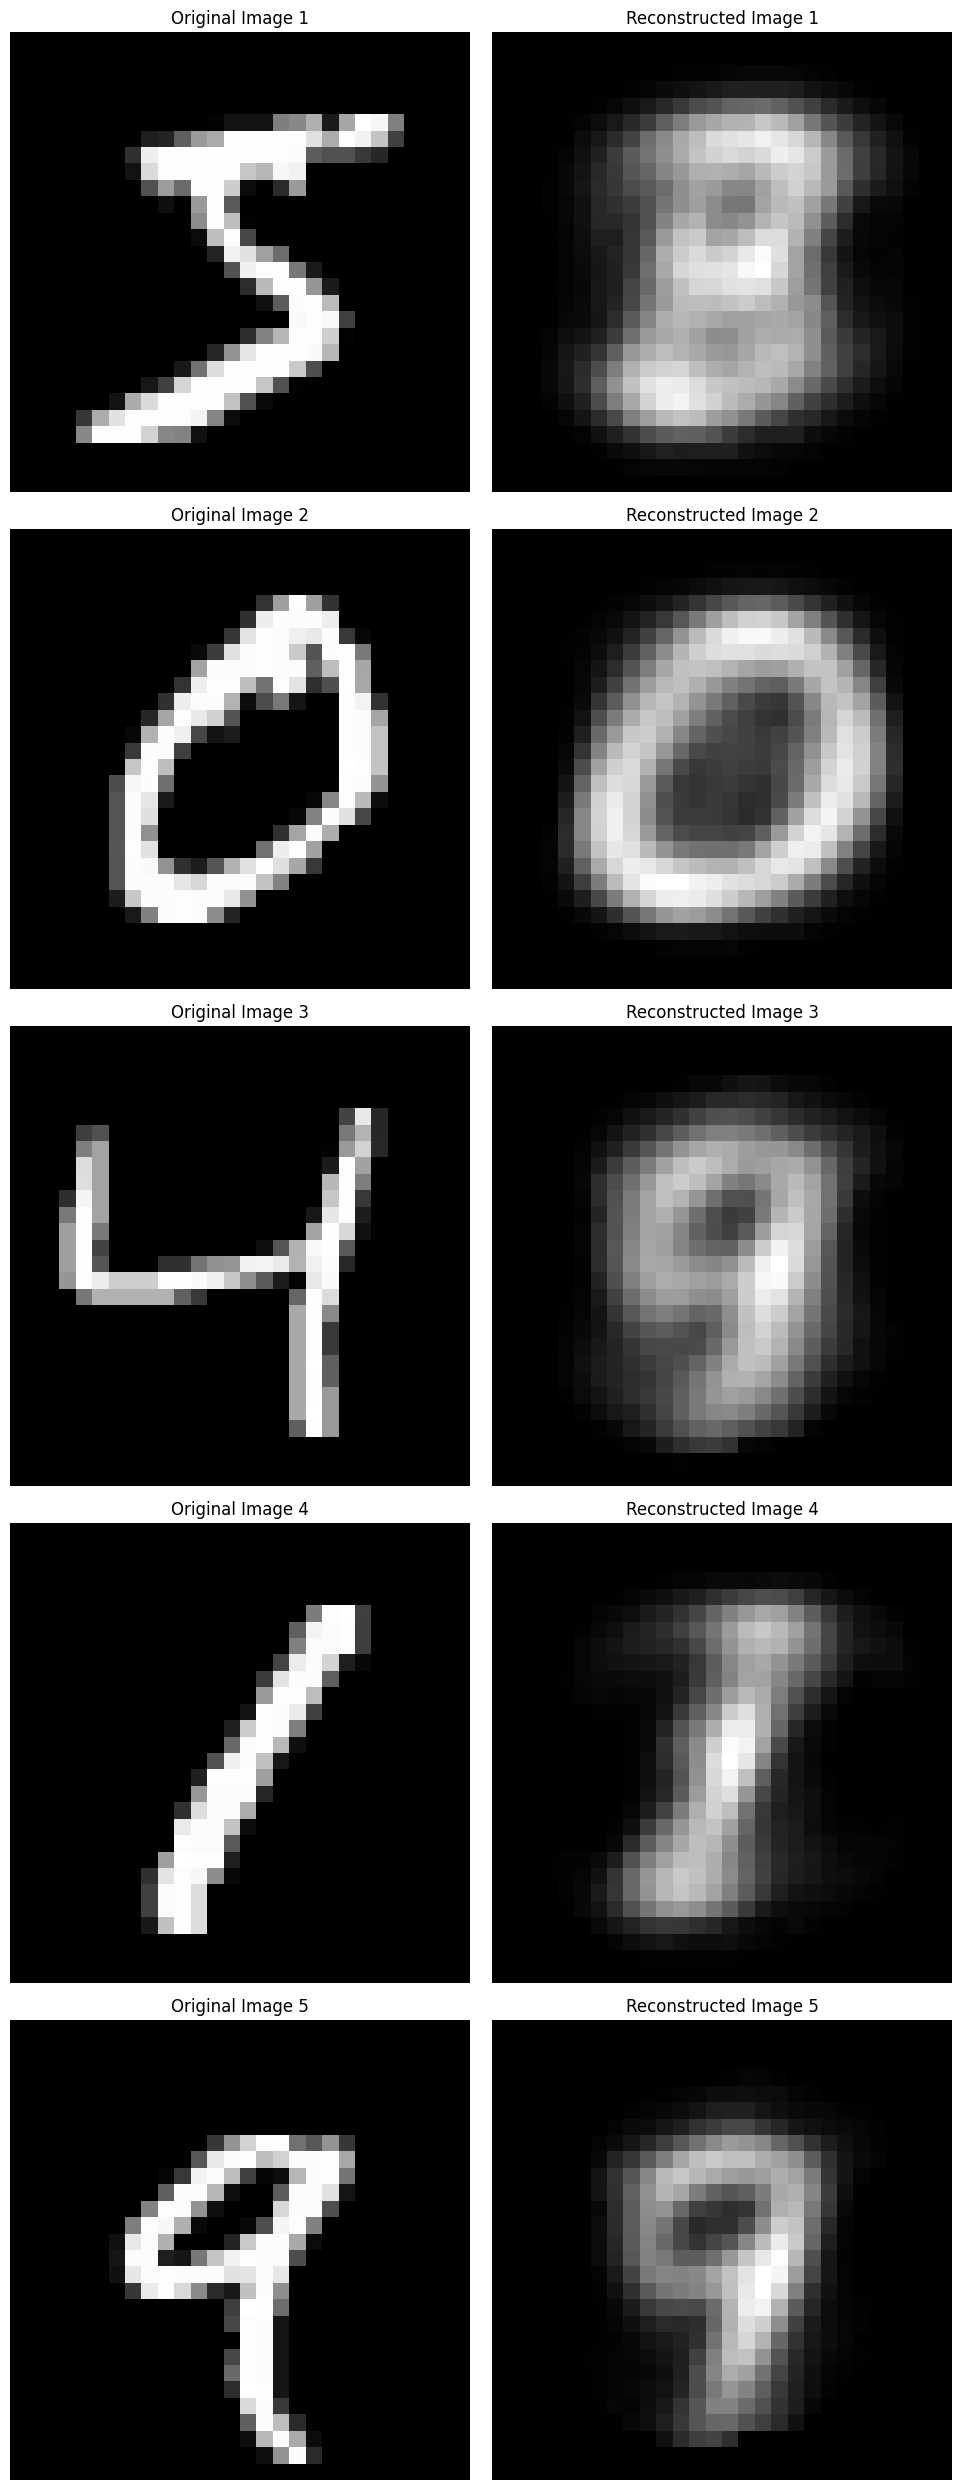

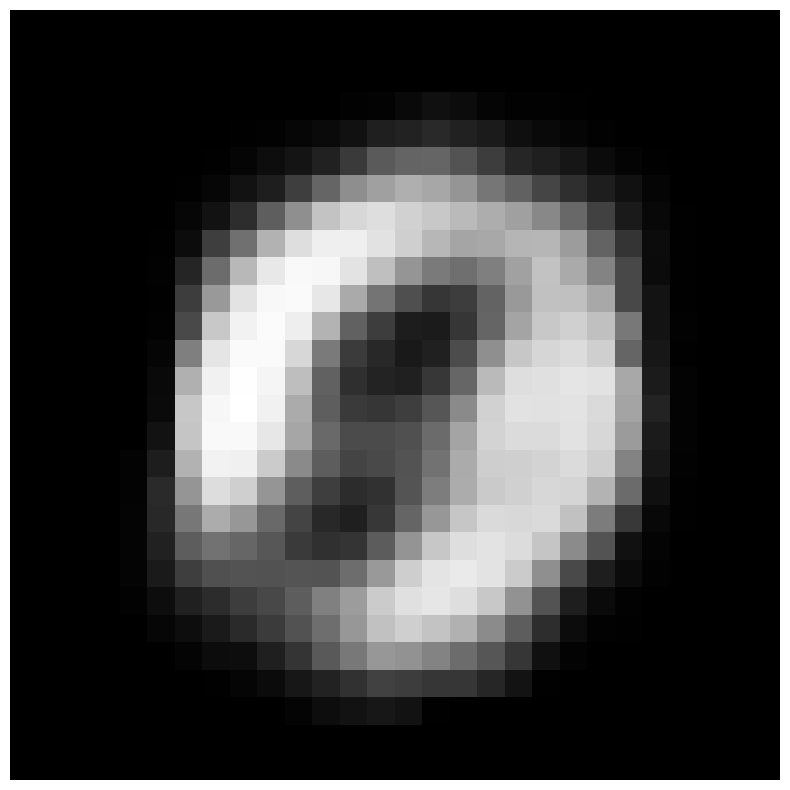

In [25]:
##################
### Problem 3(c): Evaluate VAE with ELBO loss
eval(vae_sgvb)
plot_latent_images(vae_sgvb, n=8)
##################


## f. Training with KL Divergence w/o Estimation

In [22]:
##################
### Problem 3(c): Train VAE with analytical KL
epochs = 20

hidden_dims = [128, 32, 16, 4]
assert hidden_dims[-1] == 4, "always use 4 as the latent dimension for generating a 2D image grid during evaluation"

image_shape = MNIST_dataset[0][0].shape
input_dim = torch.prod(torch.tensor(image_shape)).item()
print("input_dim: ", input_dim)

vae_kl_wo_e = VAE(input_dim, hidden_dims).to(device)
print(vae_kl_wo_e)

optimizer_vae_kl_wo_e = torch.optim.Adam(vae_kl_wo_e.parameters(),
                                lr = 1e-4,
                                weight_decay = 1e-8)

log_vae_kl_wo_e = train(MNIST_loader, vae_kl_wo_e, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=1e-3), optimizer_vae_kl_wo_e, epochs)
##################


input_dim:  784
VAE(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=16, bias=True)
    (5): ReLU()
    (6): Linear(in_features=16, out_features=4, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=4, bias=True)
    (1): ReLU()
    (2): Linear(in_features=4, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=128, bias=True)
    (7): ReLU()
    (8): Linear(in_features=128, out_features=784, bias=True)
    (9): Sigmoid()
  )
)


Epochs:   5%|▌         | 1/20 [00:04<01:26,  4.57s/it]

----
Epoch [1/20], Average Loss: 0.0729



Epochs:  10%|█         | 2/20 [00:08<01:20,  4.47s/it]

----
Epoch [2/20], Average Loss: 0.0320



Epochs:  15%|█▌        | 3/20 [00:13<01:16,  4.48s/it]

----
Epoch [3/20], Average Loss: 0.0260



Epochs:  20%|██        | 4/20 [00:17<01:12,  4.50s/it]

----
Epoch [4/20], Average Loss: 0.0253



Epochs:  25%|██▌       | 5/20 [00:22<01:08,  4.56s/it]

----
Epoch [5/20], Average Loss: 0.0251



Epochs:  30%|███       | 6/20 [00:27<01:03,  4.56s/it]

----
Epoch [6/20], Average Loss: 0.0249



Epochs:  35%|███▌      | 7/20 [00:31<00:58,  4.53s/it]

----
Epoch [7/20], Average Loss: 0.0246



Epochs:  40%|████      | 8/20 [00:36<00:54,  4.53s/it]

----
Epoch [8/20], Average Loss: 0.0243



Epochs:  45%|████▌     | 9/20 [00:40<00:49,  4.51s/it]

----
Epoch [9/20], Average Loss: 0.0241



Epochs:  50%|█████     | 10/20 [00:45<00:45,  4.51s/it]

----
Epoch [10/20], Average Loss: 0.0239



Epochs:  55%|█████▌    | 11/20 [00:49<00:40,  4.52s/it]

----
Epoch [11/20], Average Loss: 0.0238



Epochs:  60%|██████    | 12/20 [00:54<00:36,  4.58s/it]

----
Epoch [12/20], Average Loss: 0.0237



Epochs:  65%|██████▌   | 13/20 [00:59<00:31,  4.57s/it]

----
Epoch [13/20], Average Loss: 0.0236



Epochs:  70%|███████   | 14/20 [01:03<00:27,  4.63s/it]

----
Epoch [14/20], Average Loss: 0.0235



Epochs:  75%|███████▌  | 15/20 [01:08<00:23,  4.70s/it]

----
Epoch [15/20], Average Loss: 0.0235



Epochs:  80%|████████  | 16/20 [01:13<00:19,  4.89s/it]

----
Epoch [16/20], Average Loss: 0.0234



Epochs:  85%|████████▌ | 17/20 [01:18<00:14,  4.83s/it]

----
Epoch [17/20], Average Loss: 0.0233



Epochs:  90%|█████████ | 18/20 [01:23<00:09,  4.73s/it]

----
Epoch [18/20], Average Loss: 0.0233



Epochs:  95%|█████████▌| 19/20 [01:27<00:04,  4.65s/it]

----
Epoch [19/20], Average Loss: 0.0232



Epochs: 100%|██████████| 20/20 [01:32<00:00,  4.61s/it]

----
Epoch [20/20], Average Loss: 0.0231



## g. Evaluation

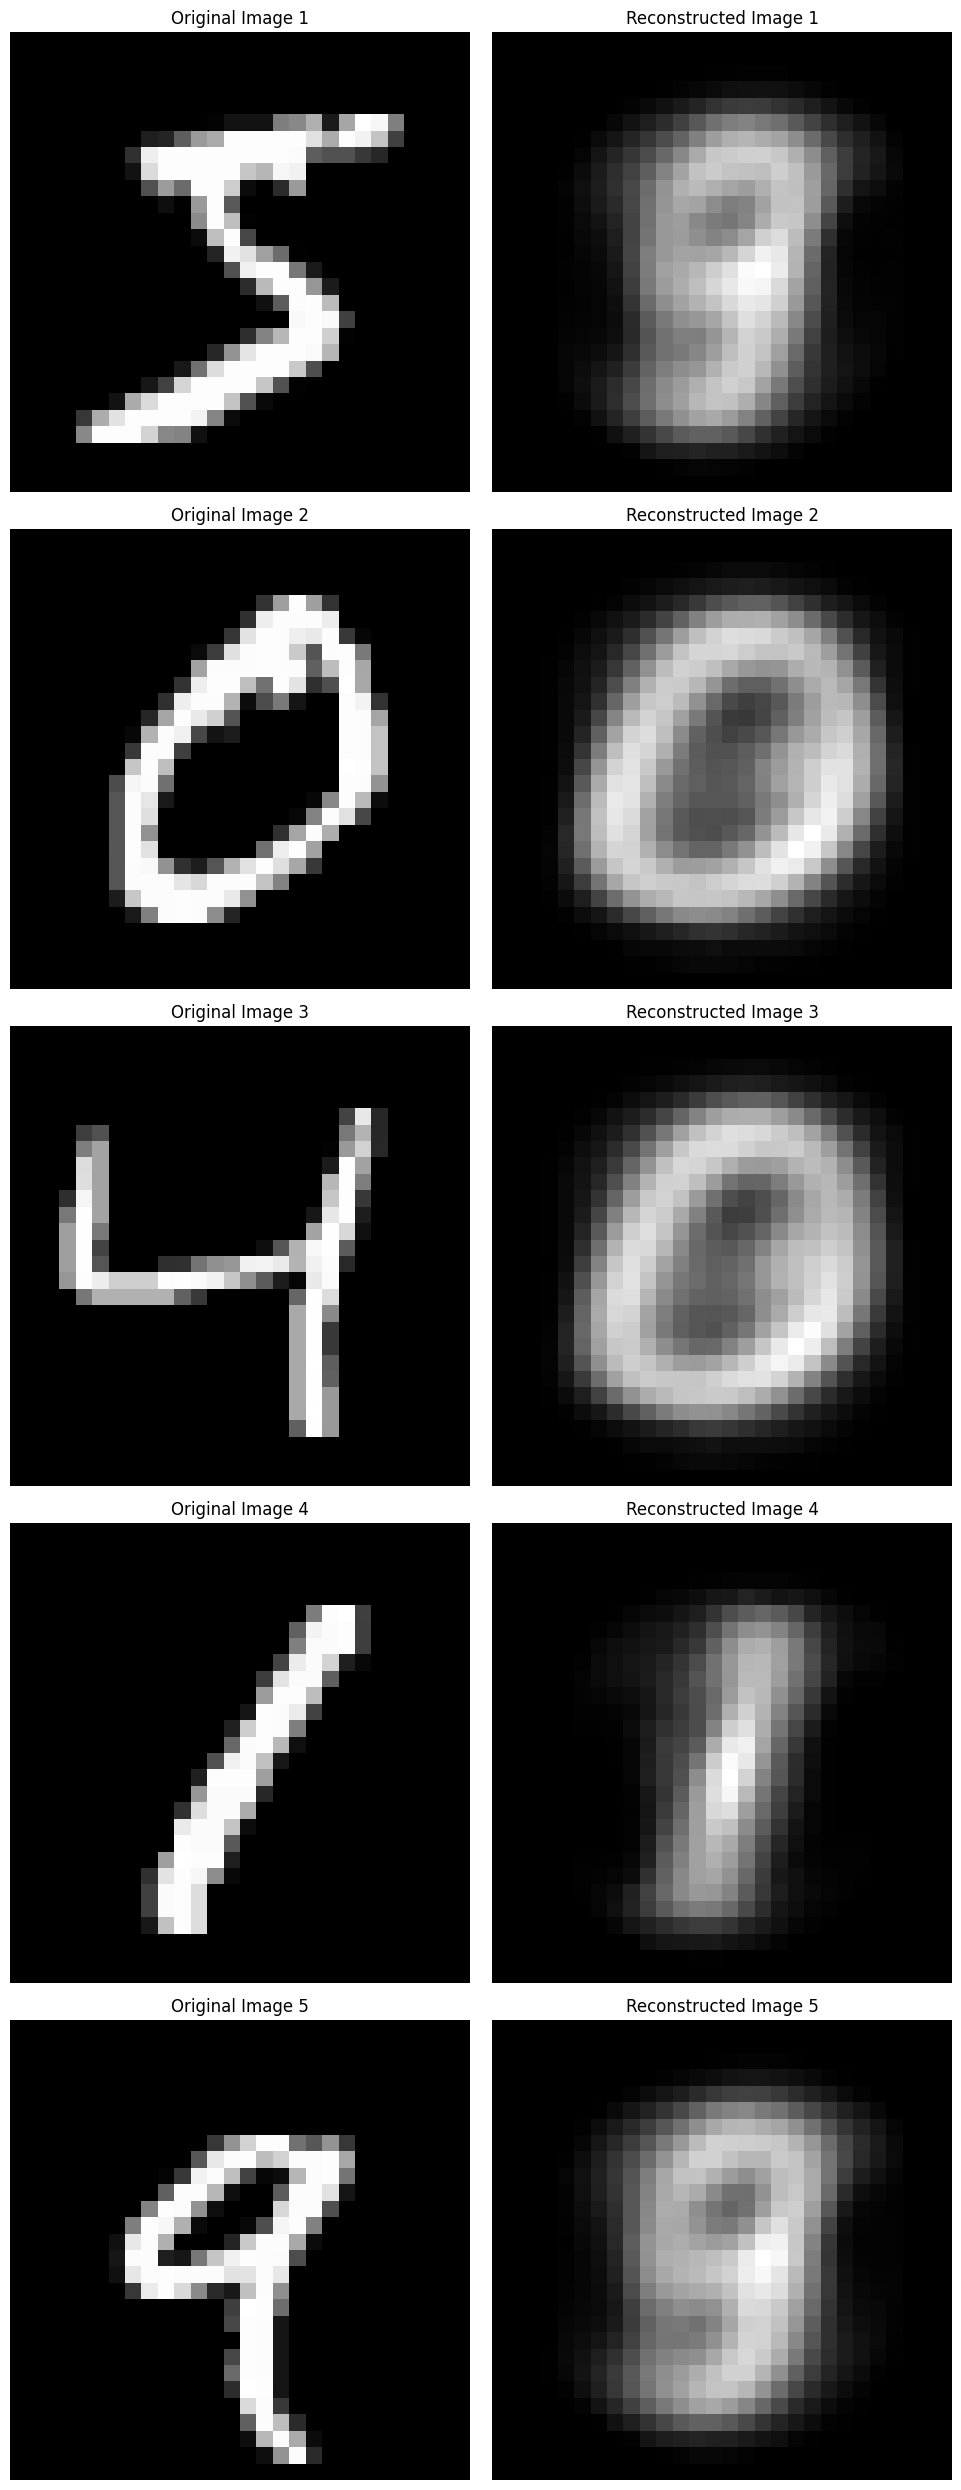

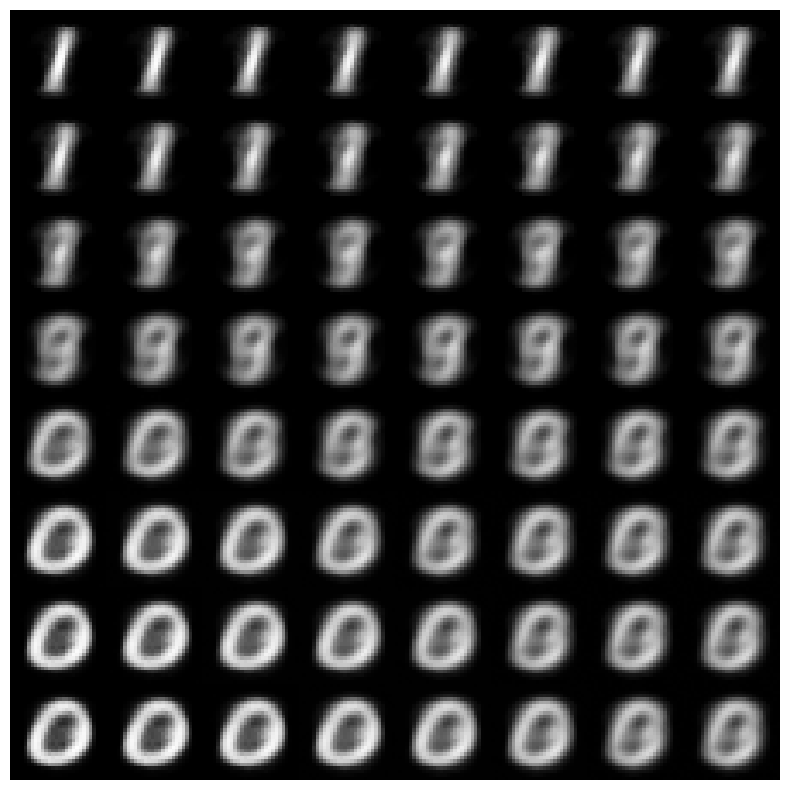

In [23]:
##################
### Problem 3(c): Evaluate VAE with analytical KL
eval(vae_kl_wo_e)
plot_latent_images(vae_kl_wo_e, n=8)
##################


# **3. Torus**

## a. Data Generation

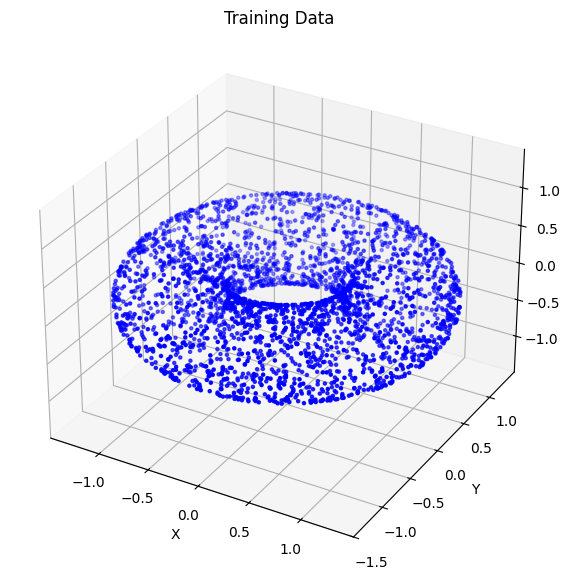

In [6]:
def generate_torus_point_cloud(R, r, num_points=1000, seed=1234):
    """
    Parameters:
    - R: Major radius of the torus (distance from the center of the tube to the center of the torus).
    - r: Minor radius of the torus (radius of the tube).
    - num_points: Number of points to sample in the point cloud.

    Returns:
    - x, y, z: Arrays containing the x, y, and z coordinates of the sampled points.
    """
    np.random.seed(seed)
    u = np.random.uniform(0, 2 * np.pi, num_points)
    np.random.seed(seed+1)
    v = np.random.uniform(0, 2 * np.pi, num_points)

    x = (R + r * np.cos(v)) * np.cos(u)
    y = (R + r * np.cos(v)) * np.sin(u)
    z = r * np.sin(v)

    points = np.vstack((x, y, z)).T

    return points

def plot_torus_point_cloud(x, y, z, ax, color='b', name='Training Data'):
    """
    Plots the 3D point cloud of a torus.
    """
    ax.scatter(x, y, z, c=color, marker='o', s=5)

    # Set equal scaling for all axes
    max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0

    mid_x = (x.max() + x.min()) * 0.5
    mid_y = (y.max() + y.min()) * 0.5
    mid_z = (z.max() + z.min()) * 0.5

    ax.set_xlim(mid_x - max_range, mid_x + max_range)
    ax.set_ylim(mid_y - max_range, mid_y + max_range)
    ax.set_zlim(mid_z - max_range, mid_z + max_range)

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')
    ax.set_title(name)
    return ax

class TorusPointCloudDataset(torch.utils.data.Dataset):
    def __init__(self, R, r, num_points=1000):
        """
        Args:
            R (float): Major radius of the torus.
            r (float): Minor radius of the torus.
            num_points (int): Number of points to generate.
        """
        points = generate_torus_point_cloud(R, r, num_points)
        self.points = torch.tensor(points, dtype=torch.float32)

    def __len__(self):
        return len(self.points)

    def __getitem__(self, idx):
        return self.points[idx], 0 # dummy label

R = 1.0
r = 0.5
num_points = 3000

torus_pc_dataset = TorusPointCloudDataset(R, r, num_points)
torus_pc_dataloader = torch.utils.data.DataLoader(torus_pc_dataset, batch_size=3000, shuffle=True)


fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(torus_pc_dataset.points[:, 0], torus_pc_dataset.points[:, 1], torus_pc_dataset.points[:, 2], ax)
plt.show()


## b. Network Architecture

In [18]:
class PositionalEncoding3D(torch.nn.Module):
    def __init__(self, num_frequencies=10):
        """
        Initializes the positional encoding for 3D coordinates.

        Args:
            num_frequencies (int): The number of different frequencies to use for encoding.
        """
        super().__init__()
        self.num_frequencies = num_frequencies
        self.frequencies = 2 ** torch.arange(num_frequencies, dtype=torch.float32)

    def forward(self, points):
        """
        Applies positional encoding to the 3D points.

        Args:
            points (torch.Tensor): N x 3 tensor of 3D coordinates.

        Returns:
            torch.Tensor: N x (6*num_frequencies) tensor of encoded coordinates.
        """
        encoded_points = []
        for i in range(points.shape[1]):  # For each dimension (x, y, z)
            for freq in self.frequencies:
                encoded_points.append(torch.sin(freq * points[:, i:i+1]))
                encoded_points.append(torch.cos(freq * points[:, i:i+1]))
        return torch.cat(encoded_points, dim=-1)

###############
### Problem 4(c): Create your own VAE
###############

class PointVAE(torch.nn.Module):
    def __init__(self, hidden_dims):
        super().__init__()

        self.pos_enc = PositionalEncoding3D()
        #############
        ### Problem 4(c): Create your own VAE
        self.vae = VAE(input_dim=self.pos_enc.num_frequencies * 6, hidden_dims=hidden_dims, decode_dim=3, use_sigmoid=False)
        #############

    def forward(self, x):
        emb = self.pos_enc(x)
        return self.vae(emb)


## c. Training

In [19]:
#############
### Problem 4(a): Train VAE on torus data
epochs = 1000

hidden_dims = [32, 16, 8] # -> 2/3 dim

point_vae = PointVAE(hidden_dims).to(device)
print(point_vae)

optimizer_point_vae = torch.optim.Adam(point_vae.parameters(),
                                lr = 1e-3,
                                weight_decay = 1e-8)

log_point_vae = train(torus_pc_dataloader, point_vae, lambda model, x: loss_func(model, x, reg_func=loss_KL_wo_E, coeff=0.0), optimizer_point_vae, epochs)
#############


PointVAE(
  (pos_enc): PositionalEncoding3D()
  (vae): VAE(
    (encoder): Sequential(
      (0): Linear(in_features=60, out_features=32, bias=True)
      (1): ReLU()
      (2): Linear(in_features=32, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=8, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=4, out_features=8, bias=True)
      (1): ReLU()
      (2): Linear(in_features=8, out_features=16, bias=True)
      (3): ReLU()
      (4): Linear(in_features=16, out_features=32, bias=True)
      (5): ReLU()
      (6): Linear(in_features=32, out_features=3, bias=True)
      (7): Sigmoid()
    )
  )
)


Epochs:   0%|          | 0/1000 [00:00<?, ?it/s]

----
Epoch [1/1000], Average Loss: 0.0317



Epochs:   0%|          | 2/1000 [00:00<00:53, 18.67it/s]

----
Epoch [2/1000], Average Loss: 0.0316



Epochs:   0%|          | 2/1000 [00:00<00:53, 18.67it/s]

----
Epoch [3/1000], Average Loss: 0.0315



Epochs:   0%|          | 4/1000 [00:00<00:55, 17.83it/s]

----
Epoch [4/1000], Average Loss: 0.0315



Epochs:   0%|          | 4/1000 [00:00<00:55, 17.83it/s]

----
Epoch [5/1000], Average Loss: 0.0314



Epochs:   0%|          | 4/1000 [00:00<00:55, 17.83it/s]

----
Epoch [6/1000], Average Loss: 0.0314



Epochs:   1%|          | 7/1000 [00:00<00:45, 21.64it/s]

----
Epoch [7/1000], Average Loss: 0.0313



Epochs:   1%|          | 7/1000 [00:00<00:45, 21.64it/s]

----
Epoch [8/1000], Average Loss: 0.0312



Epochs:   1%|          | 7/1000 [00:00<00:45, 21.64it/s]

----
Epoch [9/1000], Average Loss: 0.0312



Epochs:   1%|          | 7/1000 [00:00<00:45, 21.64it/s]

----
Epoch [10/1000], Average Loss: 0.0311



Epochs:   1%|          | 7/1000 [00:00<00:45, 21.64it/s]

----
Epoch [11/1000], Average Loss: 0.0311



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [12/1000], Average Loss: 0.0310



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [13/1000], Average Loss: 0.0310



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [14/1000], Average Loss: 0.0309



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [15/1000], Average Loss: 0.0308



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [16/1000], Average Loss: 0.0308



Epochs:   1%|          | 12/1000 [00:00<00:31, 31.39it/s]

----
Epoch [17/1000], Average Loss: 0.0307



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [18/1000], Average Loss: 0.0307



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [19/1000], Average Loss: 0.0306



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [20/1000], Average Loss: 0.0305



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [21/1000], Average Loss: 0.0305



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [22/1000], Average Loss: 0.0304



Epochs:   2%|▏         | 18/1000 [00:00<00:32, 30.02it/s]

----
Epoch [23/1000], Average Loss: 0.0303



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [24/1000], Average Loss: 0.0303



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [25/1000], Average Loss: 0.0302



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [26/1000], Average Loss: 0.0301



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [27/1000], Average Loss: 0.0301



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [28/1000], Average Loss: 0.0300



Epochs:   2%|▏         | 24/1000 [00:00<00:26, 36.40it/s]

----
Epoch [29/1000], Average Loss: 0.0299



Epochs:   3%|▎         | 29/1000 [00:00<00:24, 38.94it/s]

----
Epoch [30/1000], Average Loss: 0.0298



Epochs:   3%|▎         | 29/1000 [00:00<00:24, 38.94it/s]

----
Epoch [31/1000], Average Loss: 0.0297



Epochs:   3%|▎         | 29/1000 [00:00<00:24, 38.94it/s]

----
Epoch [32/1000], Average Loss: 0.0296



Epochs:   3%|▎         | 29/1000 [00:00<00:24, 38.94it/s]

----
Epoch [33/1000], Average Loss: 0.0295



Epochs:   3%|▎         | 34/1000 [00:00<00:23, 40.80it/s]

----
Epoch [34/1000], Average Loss: 0.0294



Epochs:   3%|▎         | 34/1000 [00:01<00:23, 40.80it/s]

----
Epoch [35/1000], Average Loss: 0.0293



Epochs:   3%|▎         | 34/1000 [00:01<00:23, 40.80it/s]

----
Epoch [36/1000], Average Loss: 0.0292



Epochs:   3%|▎         | 34/1000 [00:01<00:23, 40.80it/s]

----
Epoch [37/1000], Average Loss: 0.0291



Epochs:   3%|▎         | 34/1000 [00:01<00:23, 40.80it/s]

----
Epoch [38/1000], Average Loss: 0.0290



Epochs:   4%|▍         | 39/1000 [00:01<00:23, 41.05it/s]

----
Epoch [39/1000], Average Loss: 0.0288



Epochs:   4%|▍         | 39/1000 [00:01<00:23, 41.05it/s]

----
Epoch [40/1000], Average Loss: 0.0287



Epochs:   4%|▍         | 39/1000 [00:01<00:23, 41.05it/s]

----
Epoch [41/1000], Average Loss: 0.0286



Epochs:   4%|▍         | 39/1000 [00:01<00:23, 41.05it/s]

----
Epoch [42/1000], Average Loss: 0.0284



Epochs:   4%|▍         | 39/1000 [00:01<00:23, 41.05it/s]

----
Epoch [43/1000], Average Loss: 0.0282



Epochs:   4%|▍         | 44/1000 [00:01<00:26, 35.78it/s]

----
Epoch [44/1000], Average Loss: 0.0281



Epochs:   4%|▍         | 44/1000 [00:01<00:26, 35.78it/s]

----
Epoch [45/1000], Average Loss: 0.0278



Epochs:   4%|▍         | 44/1000 [00:01<00:26, 35.78it/s]

----
Epoch [46/1000], Average Loss: 0.0277



Epochs:   4%|▍         | 44/1000 [00:01<00:26, 35.78it/s]

----
Epoch [47/1000], Average Loss: 0.0274



Epochs:   4%|▍         | 44/1000 [00:01<00:26, 35.78it/s]

----
Epoch [48/1000], Average Loss: 0.0272



Epochs:   5%|▍         | 49/1000 [00:01<00:24, 38.26it/s]

----
Epoch [49/1000], Average Loss: 0.0270



Epochs:   5%|▍         | 49/1000 [00:01<00:24, 38.26it/s]

----
Epoch [50/1000], Average Loss: 0.0268



Epochs:   5%|▍         | 49/1000 [00:01<00:24, 38.26it/s]

----
Epoch [51/1000], Average Loss: 0.0265



Epochs:   5%|▍         | 49/1000 [00:01<00:24, 38.26it/s]

----
Epoch [52/1000], Average Loss: 0.0262



Epochs:   5%|▍         | 49/1000 [00:01<00:24, 38.26it/s]

----
Epoch [53/1000], Average Loss: 0.0260



Epochs:   5%|▌         | 54/1000 [00:01<00:23, 40.13it/s]

----
Epoch [54/1000], Average Loss: 0.0257



Epochs:   5%|▌         | 54/1000 [00:01<00:23, 40.13it/s]

----
Epoch [55/1000], Average Loss: 0.0254



Epochs:   5%|▌         | 54/1000 [00:01<00:23, 40.13it/s]

----
Epoch [56/1000], Average Loss: 0.0250



Epochs:   5%|▌         | 54/1000 [00:01<00:23, 40.13it/s]

----
Epoch [57/1000], Average Loss: 0.0247



Epochs:   5%|▌         | 54/1000 [00:01<00:23, 40.13it/s]

----
Epoch [58/1000], Average Loss: 0.0244



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [59/1000], Average Loss: 0.0240



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [60/1000], Average Loss: 0.0237



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [61/1000], Average Loss: 0.0233



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [62/1000], Average Loss: 0.0230



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [63/1000], Average Loss: 0.0227



Epochs:   6%|▌         | 59/1000 [00:01<00:22, 41.69it/s]

----
Epoch [64/1000], Average Loss: 0.0223



Epochs:   6%|▋         | 64/1000 [00:01<00:25, 36.03it/s]

----
Epoch [65/1000], Average Loss: 0.0220



Epochs:   6%|▋         | 64/1000 [00:01<00:25, 36.03it/s]

----
Epoch [66/1000], Average Loss: 0.0217



Epochs:   6%|▋         | 64/1000 [00:01<00:25, 36.03it/s]

----
Epoch [67/1000], Average Loss: 0.0214



Epochs:   6%|▋         | 64/1000 [00:01<00:25, 36.03it/s]

----
Epoch [68/1000], Average Loss: 0.0212



Epochs:   7%|▋         | 69/1000 [00:01<00:24, 38.46it/s]

----
Epoch [69/1000], Average Loss: 0.0210



Epochs:   7%|▋         | 69/1000 [00:01<00:24, 38.46it/s]

----
Epoch [70/1000], Average Loss: 0.0207



Epochs:   7%|▋         | 69/1000 [00:01<00:24, 38.46it/s]

----
Epoch [71/1000], Average Loss: 0.0206



Epochs:   7%|▋         | 69/1000 [00:01<00:24, 38.46it/s]

----
Epoch [72/1000], Average Loss: 0.0204



Epochs:   7%|▋         | 69/1000 [00:01<00:24, 38.46it/s]

----
Epoch [73/1000], Average Loss: 0.0204



Epochs:   7%|▋         | 69/1000 [00:02<00:24, 38.46it/s]

----
Epoch [74/1000], Average Loss: 0.0202



Epochs:   7%|▋         | 74/1000 [00:02<00:22, 40.55it/s]

----
Epoch [75/1000], Average Loss: 0.0201



Epochs:   7%|▋         | 74/1000 [00:02<00:22, 40.55it/s]

----
Epoch [76/1000], Average Loss: 0.0201



Epochs:   7%|▋         | 74/1000 [00:02<00:22, 40.55it/s]

----
Epoch [77/1000], Average Loss: 0.0200



Epochs:   7%|▋         | 74/1000 [00:02<00:22, 40.55it/s]

----
Epoch [78/1000], Average Loss: 0.0200



Epochs:   8%|▊         | 79/1000 [00:02<00:21, 42.43it/s]

----
Epoch [79/1000], Average Loss: 0.0199



Epochs:   8%|▊         | 79/1000 [00:02<00:21, 42.43it/s]

----
Epoch [80/1000], Average Loss: 0.0199



Epochs:   8%|▊         | 79/1000 [00:02<00:21, 42.43it/s]

----
Epoch [81/1000], Average Loss: 0.0198



Epochs:   8%|▊         | 79/1000 [00:02<00:21, 42.43it/s]

----
Epoch [82/1000], Average Loss: 0.0199



Epochs:   8%|▊         | 79/1000 [00:02<00:21, 42.43it/s]

----
Epoch [83/1000], Average Loss: 0.0199



Epochs:   8%|▊         | 84/1000 [00:02<00:21, 43.05it/s]

----
Epoch [84/1000], Average Loss: 0.0198



Epochs:   8%|▊         | 84/1000 [00:02<00:21, 43.05it/s]

----
Epoch [85/1000], Average Loss: 0.0198



Epochs:   8%|▊         | 84/1000 [00:02<00:21, 43.05it/s]

----
Epoch [86/1000], Average Loss: 0.0198



Epochs:   8%|▊         | 84/1000 [00:02<00:21, 43.05it/s]

----
Epoch [87/1000], Average Loss: 0.0198



Epochs:   8%|▊         | 84/1000 [00:02<00:21, 43.05it/s]

----
Epoch [88/1000], Average Loss: 0.0198



Epochs:   9%|▉         | 89/1000 [00:02<00:24, 36.47it/s]

----
Epoch [89/1000], Average Loss: 0.0198



Epochs:   9%|▉         | 89/1000 [00:02<00:24, 36.47it/s]

----
Epoch [90/1000], Average Loss: 0.0197



Epochs:   9%|▉         | 89/1000 [00:02<00:24, 36.47it/s]

----
Epoch [91/1000], Average Loss: 0.0197



Epochs:   9%|▉         | 89/1000 [00:02<00:24, 36.47it/s]

----
Epoch [92/1000], Average Loss: 0.0197



Epochs:   9%|▉         | 89/1000 [00:02<00:24, 36.47it/s]

----
Epoch [93/1000], Average Loss: 0.0197



Epochs:   9%|▉         | 94/1000 [00:02<00:24, 37.32it/s]

----
Epoch [94/1000], Average Loss: 0.0196



Epochs:   9%|▉         | 94/1000 [00:02<00:24, 37.32it/s]

----
Epoch [95/1000], Average Loss: 0.0196



Epochs:   9%|▉         | 94/1000 [00:02<00:24, 37.32it/s]

----
Epoch [96/1000], Average Loss: 0.0196



Epochs:   9%|▉         | 94/1000 [00:02<00:24, 37.32it/s]

----
Epoch [97/1000], Average Loss: 0.0195



Epochs:   9%|▉         | 94/1000 [00:02<00:24, 37.32it/s]

----
Epoch [98/1000], Average Loss: 0.0195



Epochs:  10%|▉         | 99/1000 [00:02<00:22, 40.18it/s]

----
Epoch [99/1000], Average Loss: 0.0195



Epochs:  10%|▉         | 99/1000 [00:02<00:22, 40.18it/s]

----
Epoch [100/1000], Average Loss: 0.0195



Epochs:  10%|▉         | 99/1000 [00:02<00:22, 40.18it/s]

----
Epoch [101/1000], Average Loss: 0.0194



Epochs:  10%|▉         | 99/1000 [00:02<00:22, 40.18it/s]

----
Epoch [102/1000], Average Loss: 0.0194



Epochs:  10%|▉         | 99/1000 [00:02<00:22, 40.18it/s]

----
Epoch [103/1000], Average Loss: 0.0194



Epochs:  10%|█         | 104/1000 [00:02<00:22, 39.96it/s]

----
Epoch [104/1000], Average Loss: 0.0193



Epochs:  10%|█         | 104/1000 [00:02<00:22, 39.96it/s]

----
Epoch [105/1000], Average Loss: 0.0192



Epochs:  10%|█         | 104/1000 [00:02<00:22, 39.96it/s]

----
Epoch [106/1000], Average Loss: 0.0192



Epochs:  10%|█         | 104/1000 [00:02<00:22, 39.96it/s]

----
Epoch [107/1000], Average Loss: 0.0192



Epochs:  10%|█         | 104/1000 [00:02<00:22, 39.96it/s]

----
Epoch [108/1000], Average Loss: 0.0192



Epochs:  11%|█         | 109/1000 [00:02<00:27, 32.98it/s]

----
Epoch [109/1000], Average Loss: 0.0192



Epochs:  11%|█         | 109/1000 [00:03<00:27, 32.98it/s]

----
Epoch [110/1000], Average Loss: 0.0191



Epochs:  11%|█         | 109/1000 [00:03<00:27, 32.98it/s]

----
Epoch [111/1000], Average Loss: 0.0191



Epochs:  11%|█         | 109/1000 [00:03<00:27, 32.98it/s]

----
Epoch [112/1000], Average Loss: 0.0191



Epochs:  11%|█▏        | 113/1000 [00:03<00:25, 34.33it/s]

----
Epoch [113/1000], Average Loss: 0.0191



Epochs:  11%|█▏        | 113/1000 [00:03<00:25, 34.33it/s]

----
Epoch [114/1000], Average Loss: 0.0190



Epochs:  11%|█▏        | 113/1000 [00:03<00:25, 34.33it/s]

----
Epoch [115/1000], Average Loss: 0.0190



Epochs:  11%|█▏        | 113/1000 [00:03<00:25, 34.33it/s]

----
Epoch [116/1000], Average Loss: 0.0189



Epochs:  12%|█▏        | 117/1000 [00:03<00:25, 35.00it/s]

----
Epoch [117/1000], Average Loss: 0.0189



Epochs:  12%|█▏        | 117/1000 [00:03<00:25, 35.00it/s]

----
Epoch [118/1000], Average Loss: 0.0189



Epochs:  12%|█▏        | 117/1000 [00:03<00:25, 35.00it/s]

----
Epoch [119/1000], Average Loss: 0.0188



Epochs:  12%|█▏        | 117/1000 [00:03<00:25, 35.00it/s]

----
Epoch [120/1000], Average Loss: 0.0188



Epochs:  12%|█▏        | 121/1000 [00:03<00:25, 34.34it/s]

----
Epoch [121/1000], Average Loss: 0.0188



Epochs:  12%|█▏        | 121/1000 [00:03<00:25, 34.34it/s]

----
Epoch [122/1000], Average Loss: 0.0187



Epochs:  12%|█▏        | 121/1000 [00:03<00:25, 34.34it/s]

----
Epoch [123/1000], Average Loss: 0.0187



Epochs:  12%|█▏        | 121/1000 [00:03<00:25, 34.34it/s]

----
Epoch [124/1000], Average Loss: 0.0187



Epochs:  12%|█▏        | 121/1000 [00:03<00:25, 34.34it/s]

----
Epoch [125/1000], Average Loss: 0.0187



Epochs:  13%|█▎        | 126/1000 [00:03<00:23, 36.75it/s]

----
Epoch [126/1000], Average Loss: 0.0186



Epochs:  13%|█▎        | 126/1000 [00:03<00:23, 36.75it/s]

----
Epoch [127/1000], Average Loss: 0.0186



Epochs:  13%|█▎        | 126/1000 [00:03<00:23, 36.75it/s]

----
Epoch [128/1000], Average Loss: 0.0186



Epochs:  13%|█▎        | 126/1000 [00:03<00:23, 36.75it/s]

----
Epoch [129/1000], Average Loss: 0.0186



Epochs:  13%|█▎        | 130/1000 [00:03<00:27, 31.65it/s]

----
Epoch [130/1000], Average Loss: 0.0185



Epochs:  13%|█▎        | 130/1000 [00:03<00:27, 31.65it/s]

----
Epoch [131/1000], Average Loss: 0.0185



Epochs:  13%|█▎        | 130/1000 [00:03<00:27, 31.65it/s]

----
Epoch [132/1000], Average Loss: 0.0184



Epochs:  13%|█▎        | 130/1000 [00:03<00:27, 31.65it/s]

----
Epoch [133/1000], Average Loss: 0.0184



Epochs:  13%|█▎        | 134/1000 [00:03<00:26, 33.03it/s]

----
Epoch [134/1000], Average Loss: 0.0184



Epochs:  13%|█▎        | 134/1000 [00:03<00:26, 33.03it/s]

----
Epoch [135/1000], Average Loss: 0.0184



Epochs:  13%|█▎        | 134/1000 [00:03<00:26, 33.03it/s]

----
Epoch [136/1000], Average Loss: 0.0183



----
Epoch [137/1000], Average Loss: 0.0183


Epochs:  13%|█▎        | 134/1000 [00:03<00:26, 33.03it/s]

Epochs:  13%|█▎        | 134/1000 [00:03<00:26, 33.03it/s]

----
Epoch [138/1000], Average Loss: 0.0182



Epochs:  14%|█▍        | 139/1000 [00:03<00:23, 36.60it/s]

----
Epoch [139/1000], Average Loss: 0.0182



Epochs:  14%|█▍        | 139/1000 [00:03<00:23, 36.60it/s]

----
Epoch [140/1000], Average Loss: 0.0182



Epochs:  14%|█▍        | 139/1000 [00:03<00:23, 36.60it/s]

----
Epoch [141/1000], Average Loss: 0.0182



Epochs:  14%|█▍        | 139/1000 [00:03<00:23, 36.60it/s]

----
Epoch [142/1000], Average Loss: 0.0181



Epochs:  14%|█▍        | 139/1000 [00:03<00:23, 36.60it/s]

----
Epoch [143/1000], Average Loss: 0.0181



Epochs:  14%|█▍        | 144/1000 [00:03<00:22, 38.89it/s]

----
Epoch [144/1000], Average Loss: 0.0181



Epochs:  14%|█▍        | 144/1000 [00:03<00:22, 38.89it/s]

----
Epoch [145/1000], Average Loss: 0.0180



Epochs:  14%|█▍        | 144/1000 [00:03<00:22, 38.89it/s]

----
Epoch [146/1000], Average Loss: 0.0180



Epochs:  14%|█▍        | 144/1000 [00:04<00:22, 38.89it/s]

----
Epoch [147/1000], Average Loss: 0.0180



Epochs:  14%|█▍        | 144/1000 [00:04<00:22, 38.89it/s]

----
Epoch [148/1000], Average Loss: 0.0179



Epochs:  15%|█▍        | 149/1000 [00:04<00:25, 33.62it/s]

----
Epoch [149/1000], Average Loss: 0.0179



Epochs:  15%|█▍        | 149/1000 [00:04<00:25, 33.62it/s]

----
Epoch [150/1000], Average Loss: 0.0179



Epochs:  15%|█▍        | 149/1000 [00:04<00:25, 33.62it/s]

----
Epoch [151/1000], Average Loss: 0.0179



Epochs:  15%|█▍        | 149/1000 [00:04<00:25, 33.62it/s]

----
Epoch [152/1000], Average Loss: 0.0178



Epochs:  15%|█▍        | 149/1000 [00:04<00:25, 33.62it/s]

----
Epoch [153/1000], Average Loss: 0.0178



Epochs:  15%|█▌        | 154/1000 [00:04<00:22, 37.08it/s]

----
Epoch [154/1000], Average Loss: 0.0178



Epochs:  15%|█▌        | 154/1000 [00:04<00:22, 37.08it/s]

----
Epoch [155/1000], Average Loss: 0.0177



Epochs:  15%|█▌        | 154/1000 [00:04<00:22, 37.08it/s]

----
Epoch [156/1000], Average Loss: 0.0177



Epochs:  15%|█▌        | 154/1000 [00:04<00:22, 37.08it/s]

----
Epoch [157/1000], Average Loss: 0.0177



Epochs:  15%|█▌        | 154/1000 [00:04<00:22, 37.08it/s]

----
Epoch [158/1000], Average Loss: 0.0177



Epochs:  16%|█▌        | 159/1000 [00:04<00:21, 39.15it/s]

----
Epoch [159/1000], Average Loss: 0.0176



Epochs:  16%|█▌        | 159/1000 [00:04<00:21, 39.15it/s]

----
Epoch [160/1000], Average Loss: 0.0176



Epochs:  16%|█▌        | 159/1000 [00:04<00:21, 39.15it/s]

----
Epoch [161/1000], Average Loss: 0.0176



Epochs:  16%|█▌        | 159/1000 [00:04<00:21, 39.15it/s]

----
Epoch [162/1000], Average Loss: 0.0176



Epochs:  16%|█▌        | 159/1000 [00:04<00:21, 39.15it/s]

----
Epoch [163/1000], Average Loss: 0.0176



Epochs:  16%|█▋        | 164/1000 [00:04<00:20, 39.96it/s]

----
Epoch [164/1000], Average Loss: 0.0175



Epochs:  16%|█▋        | 164/1000 [00:04<00:20, 39.96it/s]

----
Epoch [165/1000], Average Loss: 0.0175



Epochs:  16%|█▋        | 164/1000 [00:04<00:20, 39.96it/s]

----
Epoch [166/1000], Average Loss: 0.0175



Epochs:  16%|█▋        | 164/1000 [00:04<00:20, 39.96it/s]

----
Epoch [167/1000], Average Loss: 0.0174



Epochs:  16%|█▋        | 164/1000 [00:04<00:20, 39.96it/s]

----
Epoch [168/1000], Average Loss: 0.0174



Epochs:  17%|█▋        | 169/1000 [00:04<00:21, 38.64it/s]

----
Epoch [169/1000], Average Loss: 0.0174



Epochs:  17%|█▋        | 169/1000 [00:04<00:21, 38.64it/s]

----
Epoch [170/1000], Average Loss: 0.0174



Epochs:  17%|█▋        | 169/1000 [00:04<00:21, 38.64it/s]

----
Epoch [171/1000], Average Loss: 0.0174



Epochs:  17%|█▋        | 169/1000 [00:04<00:21, 38.64it/s]

----
Epoch [172/1000], Average Loss: 0.0173



Epochs:  17%|█▋        | 173/1000 [00:04<00:24, 33.53it/s]

----
Epoch [173/1000], Average Loss: 0.0173



Epochs:  17%|█▋        | 173/1000 [00:04<00:24, 33.53it/s]

----
Epoch [174/1000], Average Loss: 0.0173



Epochs:  17%|█▋        | 173/1000 [00:04<00:24, 33.53it/s]

----
Epoch [175/1000], Average Loss: 0.0173



Epochs:  17%|█▋        | 173/1000 [00:04<00:24, 33.53it/s]

----
Epoch [176/1000], Average Loss: 0.0172



Epochs:  17%|█▋        | 173/1000 [00:04<00:24, 33.53it/s]

----
Epoch [177/1000], Average Loss: 0.0172



Epochs:  18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

----
Epoch [178/1000], Average Loss: 0.0172



Epochs:  18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

----
Epoch [179/1000], Average Loss: 0.0172



Epochs:  18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

----
Epoch [180/1000], Average Loss: 0.0172



Epochs:  18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

----
Epoch [181/1000], Average Loss: 0.0171



Epochs:  18%|█▊        | 178/1000 [00:04<00:22, 35.95it/s]

----
Epoch [182/1000], Average Loss: 0.0171



Epochs:  18%|█▊        | 183/1000 [00:05<00:21, 38.06it/s]

----
Epoch [183/1000], Average Loss: 0.0171



Epochs:  18%|█▊        | 183/1000 [00:05<00:21, 38.06it/s]

----
Epoch [184/1000], Average Loss: 0.0171



Epochs:  18%|█▊        | 183/1000 [00:05<00:21, 38.06it/s]

----
Epoch [185/1000], Average Loss: 0.0170



Epochs:  18%|█▊        | 183/1000 [00:05<00:21, 38.06it/s]

----
Epoch [186/1000], Average Loss: 0.0170



Epochs:  18%|█▊        | 183/1000 [00:05<00:21, 38.06it/s]

----
Epoch [187/1000], Average Loss: 0.0170



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [188/1000], Average Loss: 0.0170



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [189/1000], Average Loss: 0.0170



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [190/1000], Average Loss: 0.0169



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [191/1000], Average Loss: 0.0169



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [192/1000], Average Loss: 0.0169



Epochs:  19%|█▉        | 188/1000 [00:05<00:19, 40.90it/s]

----
Epoch [193/1000], Average Loss: 0.0169



Epochs:  19%|█▉        | 193/1000 [00:05<00:20, 39.76it/s]

----
Epoch [194/1000], Average Loss: 0.0169



Epochs:  19%|█▉        | 193/1000 [00:05<00:20, 39.76it/s]

----
Epoch [195/1000], Average Loss: 0.0168



Epochs:  19%|█▉        | 193/1000 [00:05<00:20, 39.76it/s]

----
Epoch [196/1000], Average Loss: 0.0168



Epochs:  19%|█▉        | 193/1000 [00:05<00:20, 39.76it/s]

----
Epoch [197/1000], Average Loss: 0.0168



Epochs:  20%|█▉        | 198/1000 [00:05<00:24, 33.02it/s]

----
Epoch [198/1000], Average Loss: 0.0168



Epochs:  20%|█▉        | 198/1000 [00:05<00:24, 33.02it/s]

----
Epoch [199/1000], Average Loss: 0.0168



Epochs:  20%|█▉        | 198/1000 [00:05<00:24, 33.02it/s]

----
Epoch [200/1000], Average Loss: 0.0167



Epochs:  20%|█▉        | 198/1000 [00:05<00:24, 33.02it/s]

----
Epoch [201/1000], Average Loss: 0.0167



Epochs:  20%|██        | 202/1000 [00:05<00:23, 34.48it/s]

----
Epoch [202/1000], Average Loss: 0.0167



Epochs:  20%|██        | 202/1000 [00:05<00:23, 34.48it/s]

----
Epoch [203/1000], Average Loss: 0.0167



Epochs:  20%|██        | 202/1000 [00:05<00:23, 34.48it/s]

----
Epoch [204/1000], Average Loss: 0.0166



Epochs:  20%|██        | 202/1000 [00:05<00:23, 34.48it/s]

----
Epoch [205/1000], Average Loss: 0.0166



Epochs:  21%|██        | 206/1000 [00:05<00:22, 35.71it/s]

----
Epoch [206/1000], Average Loss: 0.0166



Epochs:  21%|██        | 206/1000 [00:05<00:22, 35.71it/s]

----
Epoch [207/1000], Average Loss: 0.0166



Epochs:  21%|██        | 206/1000 [00:05<00:22, 35.71it/s]

----
Epoch [208/1000], Average Loss: 0.0166



Epochs:  21%|██        | 206/1000 [00:05<00:22, 35.71it/s]

----
Epoch [209/1000], Average Loss: 0.0165



Epochs:  21%|██        | 206/1000 [00:05<00:22, 35.71it/s]

----
Epoch [210/1000], Average Loss: 0.0165



Epochs:  21%|██        | 211/1000 [00:05<00:21, 36.84it/s]

----
Epoch [211/1000], Average Loss: 0.0165



Epochs:  21%|██        | 211/1000 [00:05<00:21, 36.84it/s]

----
Epoch [212/1000], Average Loss: 0.0165



Epochs:  21%|██        | 211/1000 [00:05<00:21, 36.84it/s]

----
Epoch [213/1000], Average Loss: 0.0165



Epochs:  21%|██        | 211/1000 [00:05<00:21, 36.84it/s]

----
Epoch [214/1000], Average Loss: 0.0164



Epochs:  21%|██        | 211/1000 [00:05<00:21, 36.84it/s]

----
Epoch [215/1000], Average Loss: 0.0164



Epochs:  22%|██▏       | 216/1000 [00:05<00:19, 39.87it/s]

----
Epoch [216/1000], Average Loss: 0.0164



Epochs:  22%|██▏       | 216/1000 [00:05<00:19, 39.87it/s]

----
Epoch [217/1000], Average Loss: 0.0164



Epochs:  22%|██▏       | 216/1000 [00:06<00:19, 39.87it/s]

----
Epoch [218/1000], Average Loss: 0.0164



Epochs:  22%|██▏       | 216/1000 [00:06<00:19, 39.87it/s]

----
Epoch [219/1000], Average Loss: 0.0163



Epochs:  22%|██▏       | 216/1000 [00:06<00:19, 39.87it/s]

----
Epoch [220/1000], Average Loss: 0.0163



Epochs:  22%|██▏       | 221/1000 [00:06<00:23, 33.68it/s]

----
Epoch [221/1000], Average Loss: 0.0163



Epochs:  22%|██▏       | 221/1000 [00:06<00:23, 33.68it/s]

----
Epoch [222/1000], Average Loss: 0.0163



Epochs:  22%|██▏       | 221/1000 [00:06<00:23, 33.68it/s]

----
Epoch [223/1000], Average Loss: 0.0162



Epochs:  22%|██▏       | 221/1000 [00:06<00:23, 33.68it/s]

----
Epoch [224/1000], Average Loss: 0.0162



Epochs:  22%|██▏       | 221/1000 [00:06<00:23, 33.68it/s]

----
Epoch [225/1000], Average Loss: 0.0162



Epochs:  23%|██▎       | 226/1000 [00:06<00:21, 36.26it/s]

----
Epoch [226/1000], Average Loss: 0.0162



Epochs:  23%|██▎       | 226/1000 [00:06<00:21, 36.26it/s]

----
Epoch [227/1000], Average Loss: 0.0161



Epochs:  23%|██▎       | 226/1000 [00:06<00:21, 36.26it/s]

----
Epoch [228/1000], Average Loss: 0.0161



Epochs:  23%|██▎       | 226/1000 [00:06<00:21, 36.26it/s]

----
Epoch [229/1000], Average Loss: 0.0161



Epochs:  23%|██▎       | 226/1000 [00:06<00:21, 36.26it/s]

----
Epoch [230/1000], Average Loss: 0.0161



Epochs:  23%|██▎       | 231/1000 [00:06<00:19, 38.63it/s]

----
Epoch [231/1000], Average Loss: 0.0160



Epochs:  23%|██▎       | 231/1000 [00:06<00:19, 38.63it/s]

----
Epoch [232/1000], Average Loss: 0.0160



Epochs:  23%|██▎       | 231/1000 [00:06<00:19, 38.63it/s]

----
Epoch [233/1000], Average Loss: 0.0160



Epochs:  23%|██▎       | 231/1000 [00:06<00:19, 38.63it/s]

----
Epoch [234/1000], Average Loss: 0.0159



Epochs:  23%|██▎       | 231/1000 [00:06<00:19, 38.63it/s]

----
Epoch [235/1000], Average Loss: 0.0159



Epochs:  24%|██▎       | 236/1000 [00:06<00:18, 41.32it/s]

----
Epoch [236/1000], Average Loss: 0.0159



Epochs:  24%|██▎       | 236/1000 [00:06<00:18, 41.32it/s]

----
Epoch [237/1000], Average Loss: 0.0159



----
Epoch [238/1000], Average Loss: 0.0158


Epochs:  24%|██▎       | 236/1000 [00:06<00:18, 41.32it/s]

Epochs:  24%|██▎       | 236/1000 [00:06<00:18, 41.32it/s]

----
Epoch [239/1000], Average Loss: 0.0158



Epochs:  24%|██▎       | 236/1000 [00:06<00:18, 41.32it/s]

----
Epoch [240/1000], Average Loss: 0.0158



Epochs:  24%|██▍       | 241/1000 [00:06<00:22, 34.16it/s]

----
Epoch [241/1000], Average Loss: 0.0158



Epochs:  24%|██▍       | 241/1000 [00:06<00:22, 34.16it/s]

----
Epoch [242/1000], Average Loss: 0.0157



Epochs:  24%|██▍       | 241/1000 [00:06<00:22, 34.16it/s]

----
Epoch [243/1000], Average Loss: 0.0157



Epochs:  24%|██▍       | 241/1000 [00:06<00:22, 34.16it/s]

----
Epoch [244/1000], Average Loss: 0.0157



Epochs:  24%|██▍       | 245/1000 [00:06<00:21, 35.43it/s]

----
Epoch [245/1000], Average Loss: 0.0156



Epochs:  24%|██▍       | 245/1000 [00:06<00:21, 35.43it/s]

----
Epoch [246/1000], Average Loss: 0.0156



Epochs:  24%|██▍       | 245/1000 [00:06<00:21, 35.43it/s]

----
Epoch [247/1000], Average Loss: 0.0156



Epochs:  24%|██▍       | 245/1000 [00:06<00:21, 35.43it/s]

----
Epoch [248/1000], Average Loss: 0.0155



Epochs:  24%|██▍       | 245/1000 [00:06<00:21, 35.43it/s]

----
Epoch [249/1000], Average Loss: 0.0155



Epochs:  25%|██▌       | 250/1000 [00:06<00:19, 38.85it/s]

----
Epoch [250/1000], Average Loss: 0.0155



Epochs:  25%|██▌       | 250/1000 [00:06<00:19, 38.85it/s]

----
Epoch [251/1000], Average Loss: 0.0154



Epochs:  25%|██▌       | 250/1000 [00:06<00:19, 38.85it/s]

----
Epoch [252/1000], Average Loss: 0.0154



Epochs:  25%|██▌       | 250/1000 [00:06<00:19, 38.85it/s]

----
Epoch [253/1000], Average Loss: 0.0154



Epochs:  25%|██▌       | 250/1000 [00:06<00:19, 38.85it/s]

----
Epoch [254/1000], Average Loss: 0.0153



Epochs:  26%|██▌       | 255/1000 [00:06<00:18, 40.40it/s]

----
Epoch [255/1000], Average Loss: 0.0153



Epochs:  26%|██▌       | 255/1000 [00:06<00:18, 40.40it/s]

----
Epoch [256/1000], Average Loss: 0.0153



Epochs:  26%|██▌       | 255/1000 [00:06<00:18, 40.40it/s]

----
Epoch [257/1000], Average Loss: 0.0153



Epochs:  26%|██▌       | 255/1000 [00:06<00:18, 40.40it/s]

----
Epoch [258/1000], Average Loss: 0.0152



Epochs:  26%|██▌       | 255/1000 [00:06<00:18, 40.40it/s]

----
Epoch [259/1000], Average Loss: 0.0152



Epochs:  26%|██▌       | 255/1000 [00:07<00:18, 40.40it/s]

----
Epoch [260/1000], Average Loss: 0.0152



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [261/1000], Average Loss: 0.0151



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [262/1000], Average Loss: 0.0151



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [263/1000], Average Loss: 0.0151



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [264/1000], Average Loss: 0.0150



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [265/1000], Average Loss: 0.0150



Epochs:  26%|██▌       | 261/1000 [00:07<00:20, 36.04it/s]

----
Epoch [266/1000], Average Loss: 0.0150



Epochs:  27%|██▋       | 267/1000 [00:07<00:17, 40.78it/s]

----
Epoch [267/1000], Average Loss: 0.0150



Epochs:  27%|██▋       | 267/1000 [00:07<00:17, 40.78it/s]

----
Epoch [268/1000], Average Loss: 0.0149



Epochs:  27%|██▋       | 267/1000 [00:07<00:17, 40.78it/s]

----
Epoch [269/1000], Average Loss: 0.0149



Epochs:  27%|██▋       | 267/1000 [00:07<00:17, 40.78it/s]

----
Epoch [270/1000], Average Loss: 0.0149



Epochs:  27%|██▋       | 267/1000 [00:07<00:17, 40.78it/s]

----
Epoch [271/1000], Average Loss: 0.0148



Epochs:  27%|██▋       | 272/1000 [00:07<00:17, 41.88it/s]

----
Epoch [272/1000], Average Loss: 0.0148



Epochs:  27%|██▋       | 272/1000 [00:07<00:17, 41.88it/s]

----
Epoch [273/1000], Average Loss: 0.0148



Epochs:  27%|██▋       | 272/1000 [00:07<00:17, 41.88it/s]

----
Epoch [274/1000], Average Loss: 0.0148



Epochs:  27%|██▋       | 272/1000 [00:07<00:17, 41.88it/s]

----
Epoch [275/1000], Average Loss: 0.0148



Epochs:  27%|██▋       | 272/1000 [00:07<00:17, 41.88it/s]

----
Epoch [276/1000], Average Loss: 0.0147



Epochs:  28%|██▊       | 277/1000 [00:07<00:16, 43.53it/s]

----
Epoch [277/1000], Average Loss: 0.0147



Epochs:  28%|██▊       | 277/1000 [00:07<00:16, 43.53it/s]

----
Epoch [278/1000], Average Loss: 0.0147



Epochs:  28%|██▊       | 277/1000 [00:07<00:16, 43.53it/s]

----
Epoch [279/1000], Average Loss: 0.0147



Epochs:  28%|██▊       | 277/1000 [00:07<00:16, 43.53it/s]

----
Epoch [280/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 277/1000 [00:07<00:16, 43.53it/s]

----
Epoch [281/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 282/1000 [00:07<00:16, 43.78it/s]

----
Epoch [282/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 282/1000 [00:07<00:16, 43.78it/s]

----
Epoch [283/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 282/1000 [00:07<00:16, 43.78it/s]

----
Epoch [284/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 282/1000 [00:07<00:16, 43.78it/s]

----
Epoch [285/1000], Average Loss: 0.0146



Epochs:  28%|██▊       | 282/1000 [00:07<00:16, 43.78it/s]

----
Epoch [286/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [287/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [288/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [289/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [290/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [291/1000], Average Loss: 0.0145



Epochs:  29%|██▊       | 287/1000 [00:07<00:19, 36.49it/s]

----
Epoch [292/1000], Average Loss: 0.0145



Epochs:  29%|██▉       | 293/1000 [00:07<00:17, 40.84it/s]

----
Epoch [293/1000], Average Loss: 0.0144



Epochs:  29%|██▉       | 293/1000 [00:07<00:17, 40.84it/s]

----
Epoch [294/1000], Average Loss: 0.0144



Epochs:  29%|██▉       | 293/1000 [00:07<00:17, 40.84it/s]

----
Epoch [295/1000], Average Loss: 0.0144



Epochs:  29%|██▉       | 293/1000 [00:07<00:17, 40.84it/s]

----
Epoch [296/1000], Average Loss: 0.0144



Epochs:  29%|██▉       | 293/1000 [00:07<00:17, 40.84it/s]

----
Epoch [297/1000], Average Loss: 0.0144



Epochs:  30%|██▉       | 298/1000 [00:08<00:17, 39.61it/s]

----
Epoch [298/1000], Average Loss: 0.0144



Epochs:  30%|██▉       | 298/1000 [00:08<00:17, 39.61it/s]

----
Epoch [299/1000], Average Loss: 0.0144



Epochs:  30%|██▉       | 298/1000 [00:08<00:17, 39.61it/s]

----
Epoch [300/1000], Average Loss: 0.0144



Epochs:  30%|██▉       | 298/1000 [00:08<00:17, 39.61it/s]

----
Epoch [301/1000], Average Loss: 0.0143



Epochs:  30%|██▉       | 298/1000 [00:08<00:17, 39.61it/s]

----
Epoch [302/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [303/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [304/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [305/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [306/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [307/1000], Average Loss: 0.0143



Epochs:  30%|███       | 303/1000 [00:08<00:16, 41.13it/s]

----
Epoch [308/1000], Average Loss: 0.0143



Epochs:  31%|███       | 309/1000 [00:08<00:18, 37.75it/s]

----
Epoch [309/1000], Average Loss: 0.0143



Epochs:  31%|███       | 309/1000 [00:08<00:18, 37.75it/s]

----
Epoch [310/1000], Average Loss: 0.0143



Epochs:  31%|███       | 309/1000 [00:08<00:18, 37.75it/s]

----
Epoch [311/1000], Average Loss: 0.0142



Epochs:  31%|███       | 309/1000 [00:08<00:18, 37.75it/s]

----
Epoch [312/1000], Average Loss: 0.0142



Epochs:  31%|███       | 309/1000 [00:08<00:18, 37.75it/s]

----
Epoch [313/1000], Average Loss: 0.0142



Epochs:  31%|███▏      | 314/1000 [00:08<00:17, 39.73it/s]

----
Epoch [314/1000], Average Loss: 0.0142



Epochs:  31%|███▏      | 314/1000 [00:08<00:17, 39.73it/s]

----
Epoch [315/1000], Average Loss: 0.0142



Epochs:  31%|███▏      | 314/1000 [00:08<00:17, 39.73it/s]

----
Epoch [316/1000], Average Loss: 0.0142



Epochs:  31%|███▏      | 314/1000 [00:08<00:17, 39.73it/s]

----
Epoch [317/1000], Average Loss: 0.0142



Epochs:  31%|███▏      | 314/1000 [00:08<00:17, 39.73it/s]

----
Epoch [318/1000], Average Loss: 0.0142



Epochs:  32%|███▏      | 319/1000 [00:08<00:16, 40.91it/s]

----
Epoch [319/1000], Average Loss: 0.0142



Epochs:  32%|███▏      | 319/1000 [00:08<00:16, 40.91it/s]

----
Epoch [320/1000], Average Loss: 0.0142



Epochs:  32%|███▏      | 319/1000 [00:08<00:16, 40.91it/s]

----
Epoch [321/1000], Average Loss: 0.0142



Epochs:  32%|███▏      | 319/1000 [00:08<00:16, 40.91it/s]

----
Epoch [322/1000], Average Loss: 0.0142



Epochs:  32%|███▏      | 319/1000 [00:08<00:16, 40.91it/s]

----
Epoch [323/1000], Average Loss: 0.0141



Epochs:  32%|███▏      | 324/1000 [00:08<00:16, 42.12it/s]

----
Epoch [324/1000], Average Loss: 0.0141



Epochs:  32%|███▏      | 324/1000 [00:08<00:16, 42.12it/s]

----
Epoch [325/1000], Average Loss: 0.0141



Epochs:  32%|███▏      | 324/1000 [00:08<00:16, 42.12it/s]

----
Epoch [326/1000], Average Loss: 0.0141



Epochs:  32%|███▏      | 324/1000 [00:08<00:16, 42.12it/s]

----
Epoch [327/1000], Average Loss: 0.0141



Epochs:  32%|███▏      | 324/1000 [00:08<00:16, 42.12it/s]

----
Epoch [328/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 329/1000 [00:08<00:16, 41.81it/s]

----
Epoch [329/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 329/1000 [00:08<00:16, 41.81it/s]

----
Epoch [330/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 329/1000 [00:08<00:16, 41.81it/s]

----
Epoch [331/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 329/1000 [00:08<00:16, 41.81it/s]

----
Epoch [332/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 329/1000 [00:08<00:16, 41.81it/s]

----
Epoch [333/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 334/1000 [00:08<00:18, 36.13it/s]

----
Epoch [334/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 334/1000 [00:08<00:18, 36.13it/s]

----
Epoch [335/1000], Average Loss: 0.0141



Epochs:  33%|███▎      | 334/1000 [00:08<00:18, 36.13it/s]

----
Epoch [336/1000], Average Loss: 0.0140



Epochs:  33%|███▎      | 334/1000 [00:08<00:18, 36.13it/s]

----
Epoch [337/1000], Average Loss: 0.0140



Epochs:  33%|███▎      | 334/1000 [00:09<00:18, 36.13it/s]

----
Epoch [338/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 339/1000 [00:09<00:16, 39.04it/s]

----
Epoch [339/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 339/1000 [00:09<00:16, 39.04it/s]

----
Epoch [340/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 339/1000 [00:09<00:16, 39.04it/s]

----
Epoch [341/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 339/1000 [00:09<00:16, 39.04it/s]

----
Epoch [342/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 339/1000 [00:09<00:16, 39.04it/s]

----
Epoch [343/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [344/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [345/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [346/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [347/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [348/1000], Average Loss: 0.0140



Epochs:  34%|███▍      | 344/1000 [00:09<00:16, 39.12it/s]

----
Epoch [349/1000], Average Loss: 0.0139



Epochs:  35%|███▌      | 350/1000 [00:09<00:15, 42.36it/s]

----
Epoch [350/1000], Average Loss: 0.0139



Epochs:  35%|███▌      | 350/1000 [00:09<00:15, 42.36it/s]

----
Epoch [351/1000], Average Loss: 0.0139



Epochs:  35%|███▌      | 350/1000 [00:09<00:15, 42.36it/s]

----
Epoch [352/1000], Average Loss: 0.0139



Epochs:  35%|███▌      | 350/1000 [00:09<00:15, 42.36it/s]

----
Epoch [353/1000], Average Loss: 0.0139



Epochs:  35%|███▌      | 350/1000 [00:09<00:15, 42.36it/s]

----
Epoch [354/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 355/1000 [00:09<00:17, 36.29it/s]

----
Epoch [355/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 355/1000 [00:09<00:17, 36.29it/s]

----
Epoch [356/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 355/1000 [00:09<00:17, 36.29it/s]

----
Epoch [357/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 355/1000 [00:09<00:17, 36.29it/s]

----
Epoch [358/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 355/1000 [00:09<00:17, 36.29it/s]

----
Epoch [359/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [360/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [361/1000], Average Loss: 0.0139



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [362/1000], Average Loss: 0.0138



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [363/1000], Average Loss: 0.0138



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [364/1000], Average Loss: 0.0138



Epochs:  36%|███▌      | 360/1000 [00:09<00:16, 38.19it/s]

----
Epoch [365/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 366/1000 [00:09<00:14, 43.17it/s]

----
Epoch [366/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 366/1000 [00:09<00:14, 43.17it/s]

----
Epoch [367/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 366/1000 [00:09<00:14, 43.17it/s]

----
Epoch [368/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 366/1000 [00:09<00:14, 43.17it/s]

----
Epoch [369/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 366/1000 [00:09<00:14, 43.17it/s]

----
Epoch [370/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 371/1000 [00:09<00:14, 43.88it/s]

----
Epoch [371/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 371/1000 [00:09<00:14, 43.88it/s]

----
Epoch [372/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 371/1000 [00:09<00:14, 43.88it/s]

----
Epoch [373/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 371/1000 [00:09<00:14, 43.88it/s]

----
Epoch [374/1000], Average Loss: 0.0138



Epochs:  37%|███▋      | 371/1000 [00:09<00:14, 43.88it/s]

----
Epoch [375/1000], Average Loss: 0.0138



Epochs:  38%|███▊      | 376/1000 [00:09<00:16, 38.80it/s]

----
Epoch [376/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 376/1000 [00:09<00:16, 38.80it/s]

----
Epoch [377/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 376/1000 [00:10<00:16, 38.80it/s]

----
Epoch [378/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 376/1000 [00:10<00:16, 38.80it/s]

----
Epoch [379/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 376/1000 [00:10<00:16, 38.80it/s]

----
Epoch [380/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 381/1000 [00:10<00:15, 41.04it/s]

----
Epoch [381/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 381/1000 [00:10<00:15, 41.04it/s]

----
Epoch [382/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 381/1000 [00:10<00:15, 41.04it/s]

----
Epoch [383/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 381/1000 [00:10<00:15, 41.04it/s]

----
Epoch [384/1000], Average Loss: 0.0137



Epochs:  38%|███▊      | 381/1000 [00:10<00:15, 41.04it/s]

----
Epoch [385/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [386/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [387/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [388/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [389/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [390/1000], Average Loss: 0.0137



Epochs:  39%|███▊      | 386/1000 [00:10<00:14, 43.09it/s]

----
Epoch [391/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [392/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [393/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [394/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [395/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [396/1000], Average Loss: 0.0136



Epochs:  39%|███▉      | 392/1000 [00:10<00:13, 45.74it/s]

----
Epoch [397/1000], Average Loss: 0.0136



Epochs:  40%|███▉      | 398/1000 [00:10<00:12, 47.56it/s]

----
Epoch [398/1000], Average Loss: 0.0136



Epochs:  40%|███▉      | 398/1000 [00:10<00:12, 47.56it/s]

----
Epoch [399/1000], Average Loss: 0.0136



Epochs:  40%|███▉      | 398/1000 [00:10<00:12, 47.56it/s]

----
Epoch [400/1000], Average Loss: 0.0136



Epochs:  40%|███▉      | 398/1000 [00:10<00:12, 47.56it/s]

----
Epoch [401/1000], Average Loss: 0.0136



Epochs:  40%|███▉      | 398/1000 [00:10<00:12, 47.56it/s]

----
Epoch [402/1000], Average Loss: 0.0136



Epochs:  40%|████      | 403/1000 [00:10<00:14, 41.04it/s]

----
Epoch [403/1000], Average Loss: 0.0136



Epochs:  40%|████      | 403/1000 [00:10<00:14, 41.04it/s]

----
Epoch [404/1000], Average Loss: 0.0136



Epochs:  40%|████      | 403/1000 [00:10<00:14, 41.04it/s]

----
Epoch [405/1000], Average Loss: 0.0136



Epochs:  40%|████      | 403/1000 [00:10<00:14, 41.04it/s]

----
Epoch [406/1000], Average Loss: 0.0136



Epochs:  40%|████      | 403/1000 [00:10<00:14, 41.04it/s]

----
Epoch [407/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [408/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [409/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [410/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [411/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [412/1000], Average Loss: 0.0136



Epochs:  41%|████      | 408/1000 [00:10<00:13, 43.12it/s]

----
Epoch [413/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [414/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [415/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [416/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [417/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [418/1000], Average Loss: 0.0135



Epochs:  41%|████▏     | 414/1000 [00:10<00:12, 45.81it/s]

----
Epoch [419/1000], Average Loss: 0.0135



Epochs:  42%|████▏     | 420/1000 [00:10<00:12, 48.20it/s]

----
Epoch [420/1000], Average Loss: 0.0135



Epochs:  42%|████▏     | 420/1000 [00:11<00:12, 48.20it/s]

----
Epoch [421/1000], Average Loss: 0.0135



Epochs:  42%|████▏     | 420/1000 [00:11<00:12, 48.20it/s]

----
Epoch [422/1000], Average Loss: 0.0135



Epochs:  42%|████▏     | 420/1000 [00:11<00:12, 48.20it/s]

----
Epoch [423/1000], Average Loss: 0.0135



Epochs:  42%|████▏     | 420/1000 [00:11<00:12, 48.20it/s]

----
Epoch [424/1000], Average Loss: 0.0135



Epochs:  42%|████▎     | 425/1000 [00:11<00:15, 37.73it/s]

----
Epoch [425/1000], Average Loss: 0.0135



Epochs:  42%|████▎     | 425/1000 [00:11<00:15, 37.73it/s]

----
Epoch [426/1000], Average Loss: 0.0135



Epochs:  42%|████▎     | 425/1000 [00:11<00:15, 37.73it/s]

----
Epoch [427/1000], Average Loss: 0.0135



Epochs:  42%|████▎     | 425/1000 [00:11<00:15, 37.73it/s]

----
Epoch [428/1000], Average Loss: 0.0135



Epochs:  42%|████▎     | 425/1000 [00:11<00:15, 37.73it/s]

----
Epoch [429/1000], Average Loss: 0.0135



Epochs:  43%|████▎     | 430/1000 [00:11<00:14, 38.88it/s]

----
Epoch [430/1000], Average Loss: 0.0135



Epochs:  43%|████▎     | 430/1000 [00:11<00:14, 38.88it/s]

----
Epoch [431/1000], Average Loss: 0.0135



Epochs:  43%|████▎     | 430/1000 [00:11<00:14, 38.88it/s]

----
Epoch [432/1000], Average Loss: 0.0135



Epochs:  43%|████▎     | 430/1000 [00:11<00:14, 38.88it/s]

----
Epoch [433/1000], Average Loss: 0.0135



Epochs:  43%|████▎     | 430/1000 [00:11<00:14, 38.88it/s]

----
Epoch [434/1000], Average Loss: 0.0135



Epochs:  44%|████▎     | 435/1000 [00:11<00:13, 40.93it/s]

----
Epoch [435/1000], Average Loss: 0.0134



Epochs:  44%|████▎     | 435/1000 [00:11<00:13, 40.93it/s]

----
Epoch [436/1000], Average Loss: 0.0134



Epochs:  44%|████▎     | 435/1000 [00:11<00:13, 40.93it/s]

----
Epoch [437/1000], Average Loss: 0.0134



Epochs:  44%|████▎     | 435/1000 [00:11<00:13, 40.93it/s]

----
Epoch [438/1000], Average Loss: 0.0134



Epochs:  44%|████▎     | 435/1000 [00:11<00:13, 40.93it/s]

----
Epoch [439/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 440/1000 [00:11<00:13, 41.93it/s]

----
Epoch [440/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 440/1000 [00:11<00:13, 41.93it/s]

----
Epoch [441/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 440/1000 [00:11<00:13, 41.93it/s]

----
Epoch [442/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 440/1000 [00:11<00:13, 41.93it/s]

----
Epoch [443/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 440/1000 [00:11<00:13, 41.93it/s]

----
Epoch [444/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [445/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [446/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [447/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [448/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [449/1000], Average Loss: 0.0134



Epochs:  44%|████▍     | 445/1000 [00:11<00:15, 36.03it/s]

----
Epoch [450/1000], Average Loss: 0.0134



Epochs:  45%|████▌     | 451/1000 [00:11<00:13, 40.00it/s]

----
Epoch [451/1000], Average Loss: 0.0134



Epochs:  45%|████▌     | 451/1000 [00:11<00:13, 40.00it/s]

----
Epoch [452/1000], Average Loss: 0.0134



Epochs:  45%|████▌     | 451/1000 [00:11<00:13, 40.00it/s]

----
Epoch [453/1000], Average Loss: 0.0134



Epochs:  45%|████▌     | 451/1000 [00:11<00:13, 40.00it/s]

----
Epoch [454/1000], Average Loss: 0.0134



Epochs:  45%|████▌     | 451/1000 [00:11<00:13, 40.00it/s]

----
Epoch [455/1000], Average Loss: 0.0134



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [456/1000], Average Loss: 0.0134



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [457/1000], Average Loss: 0.0134



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [458/1000], Average Loss: 0.0134



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [459/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [460/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 456/1000 [00:11<00:12, 41.99it/s]

----
Epoch [461/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 462/1000 [00:11<00:12, 44.20it/s]

----
Epoch [462/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 462/1000 [00:11<00:12, 44.20it/s]

----
Epoch [463/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 462/1000 [00:12<00:12, 44.20it/s]

----
Epoch [464/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 462/1000 [00:12<00:12, 44.20it/s]

----
Epoch [465/1000], Average Loss: 0.0133



Epochs:  46%|████▌     | 462/1000 [00:12<00:12, 44.20it/s]

----
Epoch [466/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 467/1000 [00:12<00:13, 38.75it/s]

----
Epoch [467/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 467/1000 [00:12<00:13, 38.75it/s]

----
Epoch [468/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 467/1000 [00:12<00:13, 38.75it/s]

----
Epoch [469/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 467/1000 [00:12<00:13, 38.75it/s]

----
Epoch [470/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 467/1000 [00:12<00:13, 38.75it/s]

----
Epoch [471/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [472/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [473/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [474/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [475/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [476/1000], Average Loss: 0.0133



Epochs:  47%|████▋     | 472/1000 [00:12<00:13, 39.85it/s]

----
Epoch [477/1000], Average Loss: 0.0133



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [478/1000], Average Loss: 0.0133



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [479/1000], Average Loss: 0.0133



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [480/1000], Average Loss: 0.0133



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [481/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [482/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 478/1000 [00:12<00:12, 41.80it/s]

----
Epoch [483/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 484/1000 [00:12<00:11, 44.41it/s]

----
Epoch [484/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 484/1000 [00:12<00:11, 44.41it/s]

----
Epoch [485/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 484/1000 [00:12<00:11, 44.41it/s]

----
Epoch [486/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 484/1000 [00:12<00:11, 44.41it/s]

----
Epoch [487/1000], Average Loss: 0.0132



Epochs:  48%|████▊     | 484/1000 [00:12<00:11, 44.41it/s]

----
Epoch [488/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 489/1000 [00:12<00:11, 45.46it/s]

----
Epoch [489/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 489/1000 [00:12<00:11, 45.46it/s]

----
Epoch [490/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 489/1000 [00:12<00:11, 45.46it/s]

----
Epoch [491/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 489/1000 [00:12<00:11, 45.46it/s]

----
Epoch [492/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 489/1000 [00:12<00:11, 45.46it/s]

----
Epoch [493/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [494/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [495/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [496/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [497/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [498/1000], Average Loss: 0.0132



Epochs:  49%|████▉     | 494/1000 [00:12<00:12, 39.15it/s]

----
Epoch [499/1000], Average Loss: 0.0132



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [500/1000], Average Loss: 0.0132



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [501/1000], Average Loss: 0.0132



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [502/1000], Average Loss: 0.0132



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [503/1000], Average Loss: 0.0132



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [504/1000], Average Loss: 0.0131



Epochs:  50%|█████     | 500/1000 [00:12<00:11, 42.70it/s]

----
Epoch [505/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 506/1000 [00:13<00:10, 45.47it/s]

----
Epoch [506/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 506/1000 [00:13<00:10, 45.47it/s]

----
Epoch [507/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 506/1000 [00:13<00:10, 45.47it/s]

----
Epoch [508/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 506/1000 [00:13<00:10, 45.47it/s]

----
Epoch [509/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 506/1000 [00:13<00:10, 45.47it/s]

----
Epoch [510/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 511/1000 [00:13<00:12, 38.97it/s]

----
Epoch [511/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 511/1000 [00:13<00:12, 38.97it/s]

----
Epoch [512/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 511/1000 [00:13<00:12, 38.97it/s]

----
Epoch [513/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 511/1000 [00:13<00:12, 38.97it/s]

----
Epoch [514/1000], Average Loss: 0.0131



Epochs:  51%|█████     | 511/1000 [00:13<00:12, 38.97it/s]

----
Epoch [515/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [516/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [517/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [518/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [519/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [520/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 516/1000 [00:13<00:11, 40.77it/s]

----
Epoch [521/1000], Average Loss: 0.0131



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [522/1000], Average Loss: 0.0130



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [523/1000], Average Loss: 0.0130



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [524/1000], Average Loss: 0.0130



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [525/1000], Average Loss: 0.0130



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [526/1000], Average Loss: 0.0130



Epochs:  52%|█████▏    | 522/1000 [00:13<00:10, 44.41it/s]

----
Epoch [527/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 528/1000 [00:13<00:10, 46.65it/s]

----
Epoch [528/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 528/1000 [00:13<00:10, 46.65it/s]

----
Epoch [529/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 528/1000 [00:13<00:10, 46.65it/s]

----
Epoch [530/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 528/1000 [00:13<00:10, 46.65it/s]

----
Epoch [531/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 528/1000 [00:13<00:10, 46.65it/s]

----
Epoch [532/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 533/1000 [00:13<00:10, 46.18it/s]

----
Epoch [533/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 533/1000 [00:13<00:10, 46.18it/s]

----
Epoch [534/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 533/1000 [00:13<00:10, 46.18it/s]

----
Epoch [535/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 533/1000 [00:13<00:10, 46.18it/s]

----
Epoch [536/1000], Average Loss: 0.0130



Epochs:  53%|█████▎    | 533/1000 [00:13<00:10, 46.18it/s]

----
Epoch [537/1000], Average Loss: 0.0130



Epochs:  54%|█████▍    | 538/1000 [00:13<00:11, 40.00it/s]

----
Epoch [538/1000], Average Loss: 0.0130



Epochs:  54%|█████▍    | 538/1000 [00:13<00:11, 40.00it/s]

----
Epoch [539/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 538/1000 [00:13<00:11, 40.00it/s]

----
Epoch [540/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 538/1000 [00:13<00:11, 40.00it/s]

----
Epoch [541/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 538/1000 [00:13<00:11, 40.00it/s]

----
Epoch [542/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [543/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [544/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [545/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [546/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [547/1000], Average Loss: 0.0129



Epochs:  54%|█████▍    | 543/1000 [00:13<00:10, 42.36it/s]

----
Epoch [548/1000], Average Loss: 0.0128



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [549/1000], Average Loss: 0.0128



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [550/1000], Average Loss: 0.0128



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [551/1000], Average Loss: 0.0128



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [552/1000], Average Loss: 0.0127



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [553/1000], Average Loss: 0.0127



Epochs:  55%|█████▍    | 549/1000 [00:14<00:09, 45.14it/s]

----
Epoch [554/1000], Average Loss: 0.0126



Epochs:  56%|█████▌    | 555/1000 [00:14<00:09, 48.01it/s]

----
Epoch [555/1000], Average Loss: 0.0125



Epochs:  56%|█████▌    | 555/1000 [00:14<00:09, 48.01it/s]

----
Epoch [556/1000], Average Loss: 0.0124



Epochs:  56%|█████▌    | 555/1000 [00:14<00:09, 48.01it/s]

----
Epoch [557/1000], Average Loss: 0.0122



Epochs:  56%|█████▌    | 555/1000 [00:14<00:09, 48.01it/s]

----
Epoch [558/1000], Average Loss: 0.0121



Epochs:  56%|█████▌    | 555/1000 [00:14<00:09, 48.01it/s]

----
Epoch [559/1000], Average Loss: 0.0121



Epochs:  56%|█████▌    | 560/1000 [00:14<00:11, 39.38it/s]

----
Epoch [560/1000], Average Loss: 0.0120



Epochs:  56%|█████▌    | 560/1000 [00:14<00:11, 39.38it/s]

----
Epoch [561/1000], Average Loss: 0.0120



Epochs:  56%|█████▌    | 560/1000 [00:14<00:11, 39.38it/s]

----
Epoch [562/1000], Average Loss: 0.0120



Epochs:  56%|█████▌    | 560/1000 [00:14<00:11, 39.38it/s]

----
Epoch [563/1000], Average Loss: 0.0119



Epochs:  56%|█████▌    | 560/1000 [00:14<00:11, 39.38it/s]

----
Epoch [564/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [565/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [566/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [567/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [568/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [569/1000], Average Loss: 0.0119



Epochs:  56%|█████▋    | 565/1000 [00:14<00:10, 41.06it/s]

----
Epoch [570/1000], Average Loss: 0.0119



Epochs:  57%|█████▋    | 571/1000 [00:14<00:09, 43.12it/s]

----
Epoch [571/1000], Average Loss: 0.0119



Epochs:  57%|█████▋    | 571/1000 [00:14<00:09, 43.12it/s]

----
Epoch [572/1000], Average Loss: 0.0119



Epochs:  57%|█████▋    | 571/1000 [00:14<00:09, 43.12it/s]

----
Epoch [573/1000], Average Loss: 0.0118



Epochs:  57%|█████▋    | 571/1000 [00:14<00:09, 43.12it/s]

----
Epoch [574/1000], Average Loss: 0.0118



Epochs:  57%|█████▋    | 571/1000 [00:14<00:09, 43.12it/s]

----
Epoch [575/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 576/1000 [00:14<00:09, 44.77it/s]

----
Epoch [576/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 576/1000 [00:14<00:09, 44.77it/s]

----
Epoch [577/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 576/1000 [00:14<00:09, 44.77it/s]

----
Epoch [578/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 576/1000 [00:14<00:09, 44.77it/s]

----
Epoch [579/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 576/1000 [00:14<00:09, 44.77it/s]

----
Epoch [580/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 581/1000 [00:14<00:11, 37.08it/s]

----
Epoch [581/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 581/1000 [00:14<00:11, 37.08it/s]

----
Epoch [582/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 581/1000 [00:14<00:11, 37.08it/s]

----
Epoch [583/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 581/1000 [00:14<00:11, 37.08it/s]

----
Epoch [584/1000], Average Loss: 0.0118



Epochs:  58%|█████▊    | 581/1000 [00:14<00:11, 37.08it/s]

----
Epoch [585/1000], Average Loss: 0.0118



Epochs:  59%|█████▊    | 586/1000 [00:14<00:11, 37.54it/s]

----
Epoch [586/1000], Average Loss: 0.0118



Epochs:  59%|█████▊    | 586/1000 [00:14<00:11, 37.54it/s]

----
Epoch [587/1000], Average Loss: 0.0118



Epochs:  59%|█████▊    | 586/1000 [00:15<00:11, 37.54it/s]

----
Epoch [588/1000], Average Loss: 0.0118



Epochs:  59%|█████▊    | 586/1000 [00:15<00:11, 37.54it/s]

----
Epoch [589/1000], Average Loss: 0.0118



Epochs:  59%|█████▊    | 586/1000 [00:15<00:11, 37.54it/s]

----
Epoch [590/1000], Average Loss: 0.0118



Epochs:  59%|█████▉    | 591/1000 [00:15<00:10, 39.45it/s]

----
Epoch [591/1000], Average Loss: 0.0117



Epochs:  59%|█████▉    | 591/1000 [00:15<00:10, 39.45it/s]

----
Epoch [592/1000], Average Loss: 0.0117



Epochs:  59%|█████▉    | 591/1000 [00:15<00:10, 39.45it/s]

----
Epoch [593/1000], Average Loss: 0.0117



Epochs:  59%|█████▉    | 591/1000 [00:15<00:10, 39.45it/s]

----
Epoch [594/1000], Average Loss: 0.0117



Epochs:  59%|█████▉    | 591/1000 [00:15<00:10, 39.45it/s]

----
Epoch [595/1000], Average Loss: 0.0117



Epochs:  60%|█████▉    | 596/1000 [00:15<00:09, 40.59it/s]

----
Epoch [596/1000], Average Loss: 0.0117



Epochs:  60%|█████▉    | 596/1000 [00:15<00:09, 40.59it/s]

----
Epoch [597/1000], Average Loss: 0.0117



Epochs:  60%|█████▉    | 596/1000 [00:15<00:09, 40.59it/s]

----
Epoch [598/1000], Average Loss: 0.0117



Epochs:  60%|█████▉    | 596/1000 [00:15<00:09, 40.59it/s]

----
Epoch [599/1000], Average Loss: 0.0117



Epochs:  60%|█████▉    | 596/1000 [00:15<00:09, 40.59it/s]

----
Epoch [600/1000], Average Loss: 0.0117



Epochs:  60%|██████    | 601/1000 [00:15<00:09, 40.83it/s]

----
Epoch [601/1000], Average Loss: 0.0117



Epochs:  60%|██████    | 601/1000 [00:15<00:09, 40.83it/s]

----
Epoch [602/1000], Average Loss: 0.0117



Epochs:  60%|██████    | 601/1000 [00:15<00:09, 40.83it/s]

----
Epoch [603/1000], Average Loss: 0.0117



Epochs:  60%|██████    | 601/1000 [00:15<00:09, 40.83it/s]

----
Epoch [604/1000], Average Loss: 0.0117



Epochs:  60%|██████    | 601/1000 [00:15<00:09, 40.83it/s]

----
Epoch [605/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 606/1000 [00:15<00:10, 36.04it/s]

----
Epoch [606/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 606/1000 [00:15<00:10, 36.04it/s]

----
Epoch [607/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 606/1000 [00:15<00:10, 36.04it/s]

----
Epoch [608/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 606/1000 [00:15<00:10, 36.04it/s]

----
Epoch [609/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 606/1000 [00:15<00:10, 36.04it/s]

----
Epoch [610/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 611/1000 [00:15<00:10, 37.79it/s]

----
Epoch [611/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 611/1000 [00:15<00:10, 37.79it/s]

----
Epoch [612/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 611/1000 [00:15<00:10, 37.79it/s]

----
Epoch [613/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 611/1000 [00:15<00:10, 37.79it/s]

----
Epoch [614/1000], Average Loss: 0.0117



Epochs:  61%|██████    | 611/1000 [00:15<00:10, 37.79it/s]

----
Epoch [615/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [616/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [617/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [618/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [619/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [620/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 616/1000 [00:15<00:09, 39.97it/s]

----
Epoch [621/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 622/1000 [00:15<00:08, 43.93it/s]

----
Epoch [622/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 622/1000 [00:15<00:08, 43.93it/s]

----
Epoch [623/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 622/1000 [00:15<00:08, 43.93it/s]

----
Epoch [624/1000], Average Loss: 0.0117



Epochs:  62%|██████▏   | 622/1000 [00:15<00:08, 43.93it/s]

----
Epoch [625/1000], Average Loss: 0.0116



Epochs:  62%|██████▏   | 622/1000 [00:15<00:08, 43.93it/s]

----
Epoch [626/1000], Average Loss: 0.0117



Epochs:  63%|██████▎   | 627/1000 [00:16<00:10, 36.94it/s]

----
Epoch [627/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 627/1000 [00:16<00:10, 36.94it/s]

----
Epoch [628/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 627/1000 [00:16<00:10, 36.94it/s]

----
Epoch [629/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 627/1000 [00:16<00:10, 36.94it/s]

----
Epoch [630/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 627/1000 [00:16<00:10, 36.94it/s]

----
Epoch [631/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [632/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [633/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [634/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [635/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [636/1000], Average Loss: 0.0116



Epochs:  63%|██████▎   | 632/1000 [00:16<00:09, 39.23it/s]

----
Epoch [637/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [638/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [639/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [640/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [641/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [642/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 638/1000 [00:16<00:08, 42.62it/s]

----
Epoch [643/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 644/1000 [00:16<00:07, 46.06it/s]

----
Epoch [644/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 644/1000 [00:16<00:07, 46.06it/s]

----
Epoch [645/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 644/1000 [00:16<00:07, 46.06it/s]

----
Epoch [646/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 644/1000 [00:16<00:07, 46.06it/s]

----
Epoch [647/1000], Average Loss: 0.0116



Epochs:  64%|██████▍   | 644/1000 [00:16<00:07, 46.06it/s]

----
Epoch [648/1000], Average Loss: 0.0116



Epochs:  65%|██████▍   | 649/1000 [00:16<00:09, 38.81it/s]

----
Epoch [649/1000], Average Loss: 0.0116



Epochs:  65%|██████▍   | 649/1000 [00:16<00:09, 38.81it/s]

----
Epoch [650/1000], Average Loss: 0.0116



Epochs:  65%|██████▍   | 649/1000 [00:16<00:09, 38.81it/s]

----
Epoch [651/1000], Average Loss: 0.0116



Epochs:  65%|██████▍   | 649/1000 [00:16<00:09, 38.81it/s]

----
Epoch [652/1000], Average Loss: 0.0116



Epochs:  65%|██████▍   | 649/1000 [00:16<00:09, 38.81it/s]

----
Epoch [653/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [654/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [655/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [656/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [657/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [658/1000], Average Loss: 0.0116



Epochs:  65%|██████▌   | 654/1000 [00:16<00:08, 40.37it/s]

----
Epoch [659/1000], Average Loss: 0.0116



Epochs:  66%|██████▌   | 660/1000 [00:16<00:07, 43.69it/s]

----
Epoch [660/1000], Average Loss: 0.0116



Epochs:  66%|██████▌   | 660/1000 [00:16<00:07, 43.69it/s]

----
Epoch [661/1000], Average Loss: 0.0116



Epochs:  66%|██████▌   | 660/1000 [00:16<00:07, 43.69it/s]

----
Epoch [662/1000], Average Loss: 0.0116



Epochs:  66%|██████▌   | 660/1000 [00:16<00:07, 43.69it/s]

----
Epoch [663/1000], Average Loss: 0.0116



Epochs:  66%|██████▌   | 660/1000 [00:16<00:07, 43.69it/s]

----
Epoch [664/1000], Average Loss: 0.0116



Epochs:  66%|██████▋   | 665/1000 [00:16<00:07, 44.76it/s]

----
Epoch [665/1000], Average Loss: 0.0116



Epochs:  66%|██████▋   | 665/1000 [00:16<00:07, 44.76it/s]

----
Epoch [666/1000], Average Loss: 0.0116



Epochs:  66%|██████▋   | 665/1000 [00:16<00:07, 44.76it/s]

----
Epoch [667/1000], Average Loss: 0.0116



Epochs:  66%|██████▋   | 665/1000 [00:16<00:07, 44.76it/s]

----
Epoch [668/1000], Average Loss: 0.0116



Epochs:  66%|██████▋   | 665/1000 [00:17<00:07, 44.76it/s]

----
Epoch [669/1000], Average Loss: 0.0116



----
Epoch [670/1000], Average Loss: 0.0116



Epochs:  67%|██████▋   | 670/1000 [00:17<00:08, 37.63it/s]

----
Epoch [671/1000], Average Loss: 0.0116



Epochs:  67%|██████▋   | 670/1000 [00:17<00:08, 37.63it/s]

----
Epoch [672/1000], Average Loss: 0.0116



Epochs:  67%|██████▋   | 670/1000 [00:17<00:08, 37.63it/s]

----
Epoch [673/1000], Average Loss: 0.0116



Epochs:  67%|██████▋   | 670/1000 [00:17<00:08, 37.63it/s]

----
Epoch [674/1000], Average Loss: 0.0116



Epochs:  67%|██████▋   | 670/1000 [00:17<00:08, 37.63it/s]

----
Epoch [675/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 676/1000 [00:17<00:07, 40.72it/s]

----
Epoch [676/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 676/1000 [00:17<00:07, 40.72it/s]

----
Epoch [677/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 676/1000 [00:17<00:07, 40.72it/s]

----
Epoch [678/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 676/1000 [00:17<00:07, 40.72it/s]

----
Epoch [679/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 676/1000 [00:17<00:07, 40.72it/s]

----
Epoch [680/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 681/1000 [00:17<00:07, 42.23it/s]

----
Epoch [681/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 681/1000 [00:17<00:07, 42.23it/s]

----
Epoch [682/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 681/1000 [00:17<00:07, 42.23it/s]

----
Epoch [683/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 681/1000 [00:17<00:07, 42.23it/s]

----
Epoch [684/1000], Average Loss: 0.0116



Epochs:  68%|██████▊   | 681/1000 [00:17<00:07, 42.23it/s]

----
Epoch [685/1000], Average Loss: 0.0116



Epochs:  69%|██████▊   | 686/1000 [00:17<00:07, 44.01it/s]

----
Epoch [686/1000], Average Loss: 0.0116



Epochs:  69%|██████▊   | 686/1000 [00:17<00:07, 44.01it/s]

----
Epoch [687/1000], Average Loss: 0.0116



Epochs:  69%|██████▊   | 686/1000 [00:17<00:07, 44.01it/s]

----
Epoch [688/1000], Average Loss: 0.0116



Epochs:  69%|██████▊   | 686/1000 [00:17<00:07, 44.01it/s]

----
Epoch [689/1000], Average Loss: 0.0116



Epochs:  69%|██████▊   | 686/1000 [00:17<00:07, 44.01it/s]

----
Epoch [690/1000], Average Loss: 0.0116



Epochs:  69%|██████▉   | 691/1000 [00:17<00:08, 38.32it/s]

----
Epoch [691/1000], Average Loss: 0.0116



Epochs:  69%|██████▉   | 691/1000 [00:17<00:08, 38.32it/s]

----
Epoch [692/1000], Average Loss: 0.0116



Epochs:  69%|██████▉   | 691/1000 [00:17<00:08, 38.32it/s]

----
Epoch [693/1000], Average Loss: 0.0116



Epochs:  69%|██████▉   | 691/1000 [00:17<00:08, 38.32it/s]

----
Epoch [694/1000], Average Loss: 0.0116



Epochs:  69%|██████▉   | 691/1000 [00:17<00:08, 38.32it/s]

----
Epoch [695/1000], Average Loss: 0.0116



Epochs:  70%|██████▉   | 696/1000 [00:17<00:07, 40.10it/s]

----
Epoch [696/1000], Average Loss: 0.0116



Epochs:  70%|██████▉   | 696/1000 [00:17<00:07, 40.10it/s]

----
Epoch [697/1000], Average Loss: 0.0116



Epochs:  70%|██████▉   | 696/1000 [00:17<00:07, 40.10it/s]

----
Epoch [698/1000], Average Loss: 0.0116



Epochs:  70%|██████▉   | 696/1000 [00:17<00:07, 40.10it/s]

----
Epoch [699/1000], Average Loss: 0.0116



----
Epoch [700/1000], Average Loss: 0.0116


Epochs:  70%|██████▉   | 696/1000 [00:17<00:07, 40.10it/s]

Epochs:  70%|███████   | 701/1000 [00:17<00:07, 40.39it/s]

----
Epoch [701/1000], Average Loss: 0.0116



Epochs:  70%|███████   | 701/1000 [00:17<00:07, 40.39it/s]

----
Epoch [702/1000], Average Loss: 0.0116



Epochs:  70%|███████   | 701/1000 [00:17<00:07, 40.39it/s]

----
Epoch [703/1000], Average Loss: 0.0116



Epochs:  70%|███████   | 701/1000 [00:17<00:07, 40.39it/s]

----
Epoch [704/1000], Average Loss: 0.0116



Epochs:  70%|███████   | 701/1000 [00:17<00:07, 40.39it/s]

----
Epoch [705/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 706/1000 [00:17<00:06, 42.28it/s]

----
Epoch [706/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 706/1000 [00:17<00:06, 42.28it/s]

----
Epoch [707/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 706/1000 [00:17<00:06, 42.28it/s]

----
Epoch [708/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 706/1000 [00:17<00:06, 42.28it/s]

----
Epoch [709/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 706/1000 [00:17<00:06, 42.28it/s]

----
Epoch [710/1000], Average Loss: 0.0115



Epochs:  71%|███████   | 711/1000 [00:18<00:07, 36.69it/s]

----
Epoch [711/1000], Average Loss: 0.0116



Epochs:  71%|███████   | 711/1000 [00:18<00:07, 36.69it/s]

----
Epoch [712/1000], Average Loss: 0.0115



Epochs:  71%|███████   | 711/1000 [00:18<00:07, 36.69it/s]

----
Epoch [713/1000], Average Loss: 0.0115



Epochs:  71%|███████   | 711/1000 [00:18<00:07, 36.69it/s]

----
Epoch [714/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 715/1000 [00:18<00:07, 37.29it/s]

----
Epoch [715/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 715/1000 [00:18<00:07, 37.29it/s]

----
Epoch [716/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 715/1000 [00:18<00:07, 37.29it/s]

----
Epoch [717/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 715/1000 [00:18<00:07, 37.29it/s]

----
Epoch [718/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 715/1000 [00:18<00:07, 37.29it/s]

----
Epoch [719/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 720/1000 [00:18<00:06, 40.03it/s]

----
Epoch [720/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 720/1000 [00:18<00:06, 40.03it/s]

----
Epoch [721/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 720/1000 [00:18<00:06, 40.03it/s]

----
Epoch [722/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 720/1000 [00:18<00:06, 40.03it/s]

----
Epoch [723/1000], Average Loss: 0.0115



Epochs:  72%|███████▏  | 720/1000 [00:18<00:06, 40.03it/s]

----
Epoch [724/1000], Average Loss: 0.0115



Epochs:  72%|███████▎  | 725/1000 [00:18<00:06, 41.33it/s]

----
Epoch [725/1000], Average Loss: 0.0115



Epochs:  72%|███████▎  | 725/1000 [00:18<00:06, 41.33it/s]

----
Epoch [726/1000], Average Loss: 0.0115



Epochs:  72%|███████▎  | 725/1000 [00:18<00:06, 41.33it/s]

----
Epoch [727/1000], Average Loss: 0.0115



Epochs:  72%|███████▎  | 725/1000 [00:18<00:06, 41.33it/s]

----
Epoch [728/1000], Average Loss: 0.0115



Epochs:  72%|███████▎  | 725/1000 [00:18<00:06, 41.33it/s]

----
Epoch [729/1000], Average Loss: 0.0115



Epochs:  73%|███████▎  | 730/1000 [00:18<00:06, 42.16it/s]

----
Epoch [730/1000], Average Loss: 0.0115



Epochs:  73%|███████▎  | 730/1000 [00:18<00:06, 42.16it/s]

----
Epoch [731/1000], Average Loss: 0.0115



Epochs:  73%|███████▎  | 730/1000 [00:18<00:06, 42.16it/s]

----
Epoch [732/1000], Average Loss: 0.0115



Epochs:  73%|███████▎  | 730/1000 [00:18<00:06, 42.16it/s]

----
Epoch [733/1000], Average Loss: 0.0115



Epochs:  73%|███████▎  | 730/1000 [00:18<00:06, 42.16it/s]

----
Epoch [734/1000], Average Loss: 0.0115



Epochs:  74%|███████▎  | 735/1000 [00:18<00:07, 35.81it/s]

----
Epoch [735/1000], Average Loss: 0.0115



Epochs:  74%|███████▎  | 735/1000 [00:18<00:07, 35.81it/s]

----
Epoch [736/1000], Average Loss: 0.0115



Epochs:  74%|███████▎  | 735/1000 [00:18<00:07, 35.81it/s]

----
Epoch [737/1000], Average Loss: 0.0115



Epochs:  74%|███████▎  | 735/1000 [00:18<00:07, 35.81it/s]

----
Epoch [738/1000], Average Loss: 0.0115



Epochs:  74%|███████▎  | 735/1000 [00:18<00:07, 35.81it/s]

----
Epoch [739/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 740/1000 [00:18<00:06, 37.47it/s]

----
Epoch [740/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 740/1000 [00:18<00:06, 37.47it/s]

----
Epoch [741/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 740/1000 [00:18<00:06, 37.47it/s]

----
Epoch [742/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 740/1000 [00:18<00:06, 37.47it/s]

----
Epoch [743/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 740/1000 [00:18<00:06, 37.47it/s]

----
Epoch [744/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 745/1000 [00:18<00:06, 39.70it/s]

----
Epoch [745/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 745/1000 [00:18<00:06, 39.70it/s]

----
Epoch [746/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 745/1000 [00:18<00:06, 39.70it/s]

----
Epoch [747/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 745/1000 [00:18<00:06, 39.70it/s]

----
Epoch [748/1000], Average Loss: 0.0115



Epochs:  74%|███████▍  | 745/1000 [00:19<00:06, 39.70it/s]

----
Epoch [749/1000], Average Loss: 0.0115



Epochs:  75%|███████▌  | 750/1000 [00:19<00:06, 40.25it/s]

----
Epoch [750/1000], Average Loss: 0.0115



Epochs:  75%|███████▌  | 750/1000 [00:19<00:06, 40.25it/s]

----
Epoch [751/1000], Average Loss: 0.0115



Epochs:  75%|███████▌  | 750/1000 [00:19<00:06, 40.25it/s]

----
Epoch [752/1000], Average Loss: 0.0115



Epochs:  75%|███████▌  | 750/1000 [00:19<00:06, 40.25it/s]

----
Epoch [753/1000], Average Loss: 0.0115



Epochs:  75%|███████▌  | 750/1000 [00:19<00:06, 40.25it/s]

----
Epoch [754/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 755/1000 [00:19<00:05, 41.83it/s]

----
Epoch [755/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 755/1000 [00:19<00:05, 41.83it/s]

----
Epoch [756/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 755/1000 [00:19<00:05, 41.83it/s]

----
Epoch [757/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 755/1000 [00:19<00:05, 41.83it/s]

----
Epoch [758/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 755/1000 [00:19<00:05, 41.83it/s]

----
Epoch [759/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [760/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [761/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [762/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [763/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [764/1000], Average Loss: 0.0115



Epochs:  76%|███████▌  | 760/1000 [00:19<00:06, 36.33it/s]

----
Epoch [765/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 766/1000 [00:19<00:05, 40.68it/s]

----
Epoch [766/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 766/1000 [00:19<00:05, 40.68it/s]

----
Epoch [767/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 766/1000 [00:19<00:05, 40.68it/s]

----
Epoch [768/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 766/1000 [00:19<00:05, 40.68it/s]

----
Epoch [769/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 766/1000 [00:19<00:05, 40.68it/s]

----
Epoch [770/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [771/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [772/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [773/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [774/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [775/1000], Average Loss: 0.0115



Epochs:  77%|███████▋  | 771/1000 [00:19<00:05, 42.45it/s]

----
Epoch [776/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 777/1000 [00:19<00:04, 45.16it/s]

----
Epoch [777/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 777/1000 [00:19<00:04, 45.16it/s]

----
Epoch [778/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 777/1000 [00:19<00:04, 45.16it/s]

----
Epoch [779/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 777/1000 [00:19<00:04, 45.16it/s]

----
Epoch [780/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 777/1000 [00:19<00:04, 45.16it/s]

----
Epoch [781/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [782/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [783/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [784/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [785/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [786/1000], Average Loss: 0.0115



Epochs:  78%|███████▊  | 782/1000 [00:19<00:05, 38.23it/s]

----
Epoch [787/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 788/1000 [00:19<00:05, 42.30it/s]

----
Epoch [788/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 788/1000 [00:19<00:05, 42.30it/s]

----
Epoch [789/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 788/1000 [00:19<00:05, 42.30it/s]

----
Epoch [790/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 788/1000 [00:19<00:05, 42.30it/s]

----
Epoch [791/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 788/1000 [00:20<00:05, 42.30it/s]

----
Epoch [792/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [793/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [794/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [795/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [796/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [797/1000], Average Loss: 0.0115



Epochs:  79%|███████▉  | 793/1000 [00:20<00:04, 44.02it/s]

----
Epoch [798/1000], Average Loss: 0.0115



Epochs:  80%|███████▉  | 799/1000 [00:20<00:04, 47.06it/s]

----
Epoch [799/1000], Average Loss: 0.0115



Epochs:  80%|███████▉  | 799/1000 [00:20<00:04, 47.06it/s]

----
Epoch [800/1000], Average Loss: 0.0115



Epochs:  80%|███████▉  | 799/1000 [00:20<00:04, 47.06it/s]

----
Epoch [801/1000], Average Loss: 0.0115



Epochs:  80%|███████▉  | 799/1000 [00:20<00:04, 47.06it/s]

----
Epoch [802/1000], Average Loss: 0.0115



Epochs:  80%|███████▉  | 799/1000 [00:20<00:04, 47.06it/s]

----
Epoch [803/1000], Average Loss: 0.0115



Epochs:  80%|████████  | 804/1000 [00:20<00:05, 38.52it/s]

----
Epoch [804/1000], Average Loss: 0.0115



Epochs:  80%|████████  | 804/1000 [00:20<00:05, 38.52it/s]

----
Epoch [805/1000], Average Loss: 0.0115



Epochs:  80%|████████  | 804/1000 [00:20<00:05, 38.52it/s]

----
Epoch [806/1000], Average Loss: 0.0115



Epochs:  80%|████████  | 804/1000 [00:20<00:05, 38.52it/s]

----
Epoch [807/1000], Average Loss: 0.0115



Epochs:  80%|████████  | 804/1000 [00:20<00:05, 38.52it/s]

----
Epoch [808/1000], Average Loss: 0.0115



Epochs:  81%|████████  | 809/1000 [00:20<00:04, 40.77it/s]

----
Epoch [809/1000], Average Loss: 0.0115



Epochs:  81%|████████  | 809/1000 [00:20<00:04, 40.77it/s]

----
Epoch [810/1000], Average Loss: 0.0115



Epochs:  81%|████████  | 809/1000 [00:20<00:04, 40.77it/s]

----
Epoch [811/1000], Average Loss: 0.0115



Epochs:  81%|████████  | 809/1000 [00:20<00:04, 40.77it/s]

----
Epoch [812/1000], Average Loss: 0.0115



Epochs:  81%|████████  | 809/1000 [00:20<00:04, 40.77it/s]

----
Epoch [813/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [814/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [815/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [816/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [817/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [818/1000], Average Loss: 0.0115



Epochs:  81%|████████▏ | 814/1000 [00:20<00:04, 42.20it/s]

----
Epoch [819/1000], Average Loss: 0.0115



Epochs:  82%|████████▏ | 820/1000 [00:20<00:04, 44.65it/s]

----
Epoch [820/1000], Average Loss: 0.0115



Epochs:  82%|████████▏ | 820/1000 [00:20<00:04, 44.65it/s]

----
Epoch [821/1000], Average Loss: 0.0115



Epochs:  82%|████████▏ | 820/1000 [00:20<00:04, 44.65it/s]

----
Epoch [822/1000], Average Loss: 0.0115



Epochs:  82%|████████▏ | 820/1000 [00:20<00:04, 44.65it/s]

----
Epoch [823/1000], Average Loss: 0.0115



----
Epoch [824/1000], Average Loss: 0.0115


Epochs:  82%|████████▏ | 820/1000 [00:20<00:04, 44.65it/s]

Epochs:  82%|████████▎ | 825/1000 [00:20<00:04, 36.92it/s]

----
Epoch [825/1000], Average Loss: 0.0115



Epochs:  82%|████████▎ | 825/1000 [00:20<00:04, 36.92it/s]

----
Epoch [826/1000], Average Loss: 0.0115



Epochs:  82%|████████▎ | 825/1000 [00:20<00:04, 36.92it/s]

----
Epoch [827/1000], Average Loss: 0.0115



Epochs:  82%|████████▎ | 825/1000 [00:20<00:04, 36.92it/s]

----
Epoch [828/1000], Average Loss: 0.0115



Epochs:  82%|████████▎ | 825/1000 [00:20<00:04, 36.92it/s]

----
Epoch [829/1000], Average Loss: 0.0115



Epochs:  83%|████████▎ | 830/1000 [00:20<00:04, 38.03it/s]

----
Epoch [830/1000], Average Loss: 0.0115



Epochs:  83%|████████▎ | 830/1000 [00:21<00:04, 38.03it/s]

----
Epoch [831/1000], Average Loss: 0.0115



Epochs:  83%|████████▎ | 830/1000 [00:21<00:04, 38.03it/s]

----
Epoch [832/1000], Average Loss: 0.0115



Epochs:  83%|████████▎ | 830/1000 [00:21<00:04, 38.03it/s]

----
Epoch [833/1000], Average Loss: 0.0115



Epochs:  83%|████████▎ | 830/1000 [00:21<00:04, 38.03it/s]

----
Epoch [834/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [835/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [836/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [837/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [838/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [839/1000], Average Loss: 0.0115



Epochs:  84%|████████▎ | 835/1000 [00:21<00:04, 39.14it/s]

----
Epoch [840/1000], Average Loss: 0.0115



Epochs:  84%|████████▍ | 841/1000 [00:21<00:03, 41.69it/s]

----
Epoch [841/1000], Average Loss: 0.0115



Epochs:  84%|████████▍ | 841/1000 [00:21<00:03, 41.69it/s]

----
Epoch [842/1000], Average Loss: 0.0115



Epochs:  84%|████████▍ | 841/1000 [00:21<00:03, 41.69it/s]

----
Epoch [843/1000], Average Loss: 0.0115



Epochs:  84%|████████▍ | 841/1000 [00:21<00:03, 41.69it/s]

----
Epoch [844/1000], Average Loss: 0.0115



Epochs:  84%|████████▍ | 841/1000 [00:21<00:03, 41.69it/s]

----
Epoch [845/1000], Average Loss: 0.0115



Epochs:  85%|████████▍ | 846/1000 [00:21<00:04, 36.63it/s]

----
Epoch [846/1000], Average Loss: 0.0115



Epochs:  85%|████████▍ | 846/1000 [00:21<00:04, 36.63it/s]

----
Epoch [847/1000], Average Loss: 0.0115



Epochs:  85%|████████▍ | 846/1000 [00:21<00:04, 36.63it/s]

----
Epoch [848/1000], Average Loss: 0.0115



Epochs:  85%|████████▍ | 846/1000 [00:21<00:04, 36.63it/s]

----
Epoch [849/1000], Average Loss: 0.0115



Epochs:  85%|████████▍ | 846/1000 [00:21<00:04, 36.63it/s]

----
Epoch [850/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [851/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [852/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [853/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [854/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [855/1000], Average Loss: 0.0115



Epochs:  85%|████████▌ | 851/1000 [00:21<00:03, 39.00it/s]

----
Epoch [856/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 857/1000 [00:21<00:03, 42.49it/s]

----
Epoch [857/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 857/1000 [00:21<00:03, 42.49it/s]

----
Epoch [858/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 857/1000 [00:21<00:03, 42.49it/s]

----
Epoch [859/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 857/1000 [00:21<00:03, 42.49it/s]

----
Epoch [860/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 857/1000 [00:21<00:03, 42.49it/s]

----
Epoch [861/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 862/1000 [00:21<00:03, 43.01it/s]

----
Epoch [862/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 862/1000 [00:21<00:03, 43.01it/s]

----
Epoch [863/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 862/1000 [00:21<00:03, 43.01it/s]

----
Epoch [864/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 862/1000 [00:21<00:03, 43.01it/s]

----
Epoch [865/1000], Average Loss: 0.0115



Epochs:  86%|████████▌ | 862/1000 [00:21<00:03, 43.01it/s]

----
Epoch [866/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 867/1000 [00:21<00:03, 42.64it/s]

----
Epoch [867/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 867/1000 [00:21<00:03, 42.64it/s]

----
Epoch [868/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 867/1000 [00:21<00:03, 42.64it/s]

----
Epoch [869/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 867/1000 [00:22<00:03, 42.64it/s]

----
Epoch [870/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 867/1000 [00:22<00:03, 42.64it/s]

----
Epoch [871/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 872/1000 [00:22<00:03, 36.71it/s]

----
Epoch [872/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 872/1000 [00:22<00:03, 36.71it/s]

----
Epoch [873/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 872/1000 [00:22<00:03, 36.71it/s]

----
Epoch [874/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 872/1000 [00:22<00:03, 36.71it/s]

----
Epoch [875/1000], Average Loss: 0.0115



Epochs:  87%|████████▋ | 872/1000 [00:22<00:03, 36.71it/s]

----
Epoch [876/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 877/1000 [00:22<00:03, 38.15it/s]

----
Epoch [877/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 877/1000 [00:22<00:03, 38.15it/s]

----
Epoch [878/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 877/1000 [00:22<00:03, 38.15it/s]

----
Epoch [879/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 877/1000 [00:22<00:03, 38.15it/s]

----
Epoch [880/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 877/1000 [00:22<00:03, 38.15it/s]

----
Epoch [881/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 882/1000 [00:22<00:02, 40.86it/s]

----
Epoch [882/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 882/1000 [00:22<00:02, 40.86it/s]

----
Epoch [883/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 882/1000 [00:22<00:02, 40.86it/s]

----
Epoch [884/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 882/1000 [00:22<00:02, 40.86it/s]

----
Epoch [885/1000], Average Loss: 0.0115



Epochs:  88%|████████▊ | 882/1000 [00:22<00:02, 40.86it/s]

----
Epoch [886/1000], Average Loss: 0.0115



Epochs:  89%|████████▊ | 887/1000 [00:22<00:02, 40.93it/s]

----
Epoch [887/1000], Average Loss: 0.0115



Epochs:  89%|████████▊ | 887/1000 [00:22<00:02, 40.93it/s]

----
Epoch [888/1000], Average Loss: 0.0115



Epochs:  89%|████████▊ | 887/1000 [00:22<00:02, 40.93it/s]

----
Epoch [889/1000], Average Loss: 0.0115



Epochs:  89%|████████▊ | 887/1000 [00:22<00:02, 40.93it/s]

----
Epoch [890/1000], Average Loss: 0.0115



Epochs:  89%|████████▊ | 887/1000 [00:22<00:02, 40.93it/s]

----
Epoch [891/1000], Average Loss: 0.0115



Epochs:  89%|████████▉ | 892/1000 [00:22<00:03, 33.99it/s]

----
Epoch [892/1000], Average Loss: 0.0115



Epochs:  89%|████████▉ | 892/1000 [00:22<00:03, 33.99it/s]

----
Epoch [893/1000], Average Loss: 0.0115



Epochs:  89%|████████▉ | 892/1000 [00:22<00:03, 33.99it/s]

----
Epoch [894/1000], Average Loss: 0.0115



Epochs:  89%|████████▉ | 892/1000 [00:22<00:03, 33.99it/s]

----
Epoch [895/1000], Average Loss: 0.0115



Epochs:  89%|████████▉ | 892/1000 [00:22<00:03, 33.99it/s]

----
Epoch [896/1000], Average Loss: 0.0115



Epochs:  90%|████████▉ | 897/1000 [00:22<00:02, 36.26it/s]

----
Epoch [897/1000], Average Loss: 0.0115



Epochs:  90%|████████▉ | 897/1000 [00:22<00:02, 36.26it/s]

----
Epoch [898/1000], Average Loss: 0.0115



Epochs:  90%|████████▉ | 897/1000 [00:22<00:02, 36.26it/s]

----
Epoch [899/1000], Average Loss: 0.0115



Epochs:  90%|████████▉ | 897/1000 [00:22<00:02, 36.26it/s]

----
Epoch [900/1000], Average Loss: 0.0115



Epochs:  90%|████████▉ | 897/1000 [00:22<00:02, 36.26it/s]

----
Epoch [901/1000], Average Loss: 0.0115



Epochs:  90%|█████████ | 902/1000 [00:22<00:02, 38.05it/s]

----
Epoch [902/1000], Average Loss: 0.0115



Epochs:  90%|█████████ | 902/1000 [00:22<00:02, 38.05it/s]

----
Epoch [903/1000], Average Loss: 0.0115



Epochs:  90%|█████████ | 902/1000 [00:22<00:02, 38.05it/s]

----
Epoch [904/1000], Average Loss: 0.0115



Epochs:  90%|█████████ | 902/1000 [00:22<00:02, 38.05it/s]

----
Epoch [905/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 906/1000 [00:22<00:02, 37.77it/s]

----
Epoch [906/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 906/1000 [00:22<00:02, 37.77it/s]

----
Epoch [907/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 906/1000 [00:22<00:02, 37.77it/s]

----
Epoch [908/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 906/1000 [00:23<00:02, 37.77it/s]

----
Epoch [909/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 906/1000 [00:23<00:02, 37.77it/s]

----
Epoch [910/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 911/1000 [00:23<00:02, 39.86it/s]

----
Epoch [911/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 911/1000 [00:23<00:02, 39.86it/s]

----
Epoch [912/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 911/1000 [00:23<00:02, 39.86it/s]

----
Epoch [913/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 911/1000 [00:23<00:02, 39.86it/s]

----
Epoch [914/1000], Average Loss: 0.0115



Epochs:  91%|█████████ | 911/1000 [00:23<00:02, 39.86it/s]

----
Epoch [915/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 916/1000 [00:23<00:02, 33.41it/s]

----
Epoch [916/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 916/1000 [00:23<00:02, 33.41it/s]

----
Epoch [917/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 916/1000 [00:23<00:02, 33.41it/s]

----
Epoch [918/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 916/1000 [00:23<00:02, 33.41it/s]

----
Epoch [919/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 920/1000 [00:23<00:02, 34.70it/s]

----
Epoch [920/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 920/1000 [00:23<00:02, 34.70it/s]

----
Epoch [921/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 920/1000 [00:23<00:02, 34.70it/s]

----
Epoch [922/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 920/1000 [00:23<00:02, 34.70it/s]

----
Epoch [923/1000], Average Loss: 0.0115



Epochs:  92%|█████████▏| 920/1000 [00:23<00:02, 34.70it/s]

----
Epoch [924/1000], Average Loss: 0.0115



Epochs:  92%|█████████▎| 925/1000 [00:23<00:01, 38.01it/s]

----
Epoch [925/1000], Average Loss: 0.0115



Epochs:  92%|█████████▎| 925/1000 [00:23<00:01, 38.01it/s]

----
Epoch [926/1000], Average Loss: 0.0115



Epochs:  92%|█████████▎| 925/1000 [00:23<00:01, 38.01it/s]

----
Epoch [927/1000], Average Loss: 0.0115



Epochs:  92%|█████████▎| 925/1000 [00:23<00:01, 38.01it/s]

----
Epoch [928/1000], Average Loss: 0.0115



Epochs:  92%|█████████▎| 925/1000 [00:23<00:01, 38.01it/s]

----
Epoch [929/1000], Average Loss: 0.0115



Epochs:  93%|█████████▎| 930/1000 [00:23<00:01, 39.01it/s]

----
Epoch [930/1000], Average Loss: 0.0115



Epochs:  93%|█████████▎| 930/1000 [00:23<00:01, 39.01it/s]

----
Epoch [931/1000], Average Loss: 0.0115



Epochs:  93%|█████████▎| 930/1000 [00:23<00:01, 39.01it/s]

----
Epoch [932/1000], Average Loss: 0.0115



Epochs:  93%|█████████▎| 930/1000 [00:23<00:01, 39.01it/s]

----
Epoch [933/1000], Average Loss: 0.0115



Epochs:  93%|█████████▎| 930/1000 [00:23<00:01, 39.01it/s]

----
Epoch [934/1000], Average Loss: 0.0115



Epochs:  94%|█████████▎| 935/1000 [00:23<00:01, 33.27it/s]

----
Epoch [935/1000], Average Loss: 0.0115



Epochs:  94%|█████████▎| 935/1000 [00:23<00:01, 33.27it/s]

----
Epoch [936/1000], Average Loss: 0.0115



Epochs:  94%|█████████▎| 935/1000 [00:23<00:01, 33.27it/s]

----
Epoch [937/1000], Average Loss: 0.0115



Epochs:  94%|█████████▎| 935/1000 [00:23<00:01, 33.27it/s]

----
Epoch [938/1000], Average Loss: 0.0115



Epochs:  94%|█████████▎| 935/1000 [00:23<00:01, 33.27it/s]

----
Epoch [939/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 940/1000 [00:23<00:01, 36.43it/s]

----
Epoch [940/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 940/1000 [00:23<00:01, 36.43it/s]

----
Epoch [941/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 940/1000 [00:23<00:01, 36.43it/s]

----
Epoch [942/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 940/1000 [00:23<00:01, 36.43it/s]

----
Epoch [943/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 944/1000 [00:23<00:01, 36.36it/s]

----
Epoch [944/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 944/1000 [00:24<00:01, 36.36it/s]

----
Epoch [945/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 944/1000 [00:24<00:01, 36.36it/s]

----
Epoch [946/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 944/1000 [00:24<00:01, 36.36it/s]

----
Epoch [947/1000], Average Loss: 0.0115



Epochs:  94%|█████████▍| 944/1000 [00:24<00:01, 36.36it/s]

----
Epoch [948/1000], Average Loss: 0.0115



Epochs:  95%|█████████▍| 949/1000 [00:24<00:01, 38.05it/s]

----
Epoch [949/1000], Average Loss: 0.0115



Epochs:  95%|█████████▍| 949/1000 [00:24<00:01, 38.05it/s]

----
Epoch [950/1000], Average Loss: 0.0115



Epochs:  95%|█████████▍| 949/1000 [00:24<00:01, 38.05it/s]

----
Epoch [951/1000], Average Loss: 0.0115



Epochs:  95%|█████████▍| 949/1000 [00:24<00:01, 38.05it/s]

----
Epoch [952/1000], Average Loss: 0.0115



Epochs:  95%|█████████▌| 953/1000 [00:24<00:01, 37.62it/s]

----
Epoch [953/1000], Average Loss: 0.0115



Epochs:  95%|█████████▌| 953/1000 [00:24<00:01, 37.62it/s]

----
Epoch [954/1000], Average Loss: 0.0115



Epochs:  95%|█████████▌| 953/1000 [00:24<00:01, 37.62it/s]

----
Epoch [955/1000], Average Loss: 0.0115



Epochs:  95%|█████████▌| 953/1000 [00:24<00:01, 37.62it/s]

----
Epoch [956/1000], Average Loss: 0.0115



Epochs:  95%|█████████▌| 953/1000 [00:24<00:01, 37.62it/s]

----
Epoch [957/1000], Average Loss: 0.0115



Epochs:  96%|█████████▌| 958/1000 [00:24<00:01, 32.51it/s]

----
Epoch [958/1000], Average Loss: 0.0115



Epochs:  96%|█████████▌| 958/1000 [00:24<00:01, 32.51it/s]

----
Epoch [959/1000], Average Loss: 0.0115



Epochs:  96%|█████████▌| 958/1000 [00:24<00:01, 32.51it/s]

----
Epoch [960/1000], Average Loss: 0.0115



Epochs:  96%|█████████▌| 958/1000 [00:24<00:01, 32.51it/s]

----
Epoch [961/1000], Average Loss: 0.0115



Epochs:  96%|█████████▌| 958/1000 [00:24<00:01, 32.51it/s]

----
Epoch [962/1000], Average Loss: 0.0115



Epochs:  96%|█████████▋| 963/1000 [00:24<00:01, 35.82it/s]

----
Epoch [963/1000], Average Loss: 0.0115



Epochs:  96%|█████████▋| 963/1000 [00:24<00:01, 35.82it/s]

----
Epoch [964/1000], Average Loss: 0.0115



Epochs:  96%|█████████▋| 963/1000 [00:24<00:01, 35.82it/s]

----
Epoch [965/1000], Average Loss: 0.0115



Epochs:  96%|█████████▋| 963/1000 [00:24<00:01, 35.82it/s]

----
Epoch [966/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 967/1000 [00:24<00:00, 36.83it/s]

----
Epoch [967/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 967/1000 [00:24<00:00, 36.83it/s]

----
Epoch [968/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 967/1000 [00:24<00:00, 36.83it/s]

----
Epoch [969/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 967/1000 [00:24<00:00, 36.83it/s]

----
Epoch [970/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 967/1000 [00:24<00:00, 36.83it/s]

----
Epoch [971/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 972/1000 [00:24<00:00, 39.15it/s]

----
Epoch [972/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 972/1000 [00:24<00:00, 39.15it/s]

----
Epoch [973/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 972/1000 [00:24<00:00, 39.15it/s]

----
Epoch [974/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 972/1000 [00:24<00:00, 39.15it/s]

----
Epoch [975/1000], Average Loss: 0.0115



Epochs:  97%|█████████▋| 972/1000 [00:24<00:00, 39.15it/s]

----
Epoch [976/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 977/1000 [00:24<00:00, 40.81it/s]

----
Epoch [977/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 977/1000 [00:24<00:00, 40.81it/s]

----
Epoch [978/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 977/1000 [00:24<00:00, 40.81it/s]

----
Epoch [979/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 977/1000 [00:25<00:00, 40.81it/s]

----
Epoch [980/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 977/1000 [00:25<00:00, 40.81it/s]

----
Epoch [981/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 982/1000 [00:25<00:00, 35.34it/s]

----
Epoch [982/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 982/1000 [00:25<00:00, 35.34it/s]

----
Epoch [983/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 982/1000 [00:25<00:00, 35.34it/s]

----
Epoch [984/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 982/1000 [00:25<00:00, 35.34it/s]

----
Epoch [985/1000], Average Loss: 0.0115



Epochs:  98%|█████████▊| 982/1000 [00:25<00:00, 35.34it/s]

----
Epoch [986/1000], Average Loss: 0.0115



Epochs:  99%|█████████▊| 987/1000 [00:25<00:00, 37.78it/s]

----
Epoch [987/1000], Average Loss: 0.0115



Epochs:  99%|█████████▊| 987/1000 [00:25<00:00, 37.78it/s]

----
Epoch [988/1000], Average Loss: 0.0115



Epochs:  99%|█████████▊| 987/1000 [00:25<00:00, 37.78it/s]

----
Epoch [989/1000], Average Loss: 0.0115



Epochs:  99%|█████████▊| 987/1000 [00:25<00:00, 37.78it/s]

----
Epoch [990/1000], Average Loss: 0.0115



Epochs:  99%|█████████▊| 987/1000 [00:25<00:00, 37.78it/s]

----
Epoch [991/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [992/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [993/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [994/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [995/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [996/1000], Average Loss: 0.0115



Epochs:  99%|█████████▉| 992/1000 [00:25<00:00, 40.71it/s]

----
Epoch [997/1000], Average Loss: 0.0115



Epochs: 100%|█████████▉| 997/1000 [00:25<00:00, 40.22it/s]

----
Epoch [998/1000], Average Loss: 0.0115



Epochs: 100%|█████████▉| 997/1000 [00:25<00:00, 40.22it/s]

----
Epoch [999/1000], Average Loss: 0.0115



Epochs: 100%|██████████| 1000/1000 [00:25<00:00, 39.31it/s]

----
Epoch [1000/1000], Average Loss: 0.0115



## d. Evaluation on Reconstruction

<Axes3D: title={'center': 'Decoded Data'}, xlabel='X', ylabel='Y', zlabel='Z'>

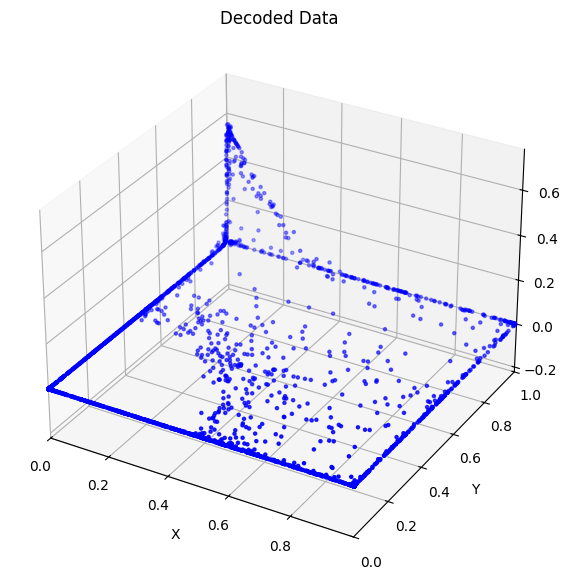

In [21]:
#############
### Problem 4(a): Evaluation on reconstruction
with torch.no_grad():
  output = point_vae(torus_pc_dataset.points.to(device))
  decoded_pc = output['imgs'].cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
#############


## e. Evaluation on Interpolation

8


C:\Users\Administrator\AppData\Local\Temp\ipykernel_26656\470380799.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))


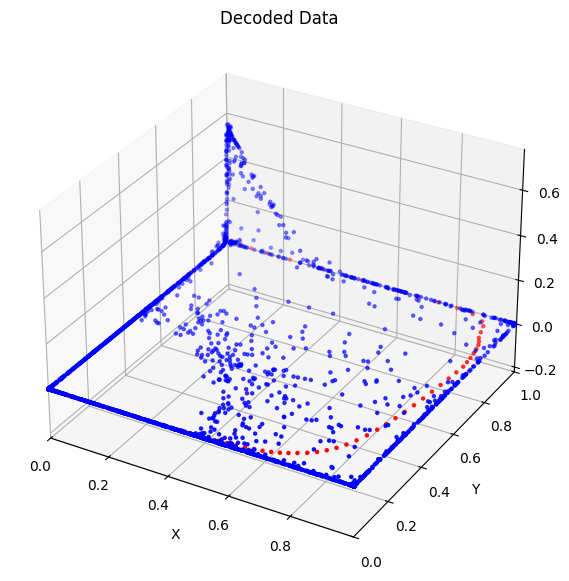

In [22]:
#############
### Problem 4(v): Evaluation on linear interpolation
z0 = point_vae(torch.tensor([[0.0, 1.0, 0.]]).to(device))['z']
z1 = point_vae(torch.tensor([[0.0, -1.0, 0.]]).to(device))['z']

print(hidden_dims[-1])
num_steps = 100

weights = torch.linspace(0, 1, num_steps).view(-1, 1).to(device)
latent_vecs = weights * z0 + (1 - weights) * z1

with torch.no_grad():
    outputs = point_vae.vae.decode(torch.tensor(latent_vecs).to(device))

lin_traj = outputs.cpu().numpy()

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
plot_torus_point_cloud(lin_traj[:, 0], lin_traj[:, 1], lin_traj[:, 2], ax, color='r', name="Decoded Data")
plot_torus_point_cloud(decoded_pc[:, 0], decoded_pc[:, 1], decoded_pc[:, 2], ax, name="Decoded Data")
plt.show()
#############
